## Final Team Project: Music Genre and Composer Classification Using Deep Learning 

## LSTM Implementation

## Date: 08/02/2025

This notebook includes data preparation, exploratory data analysis (EDA), data preprocessing, feature extraction, and the implementation of multiple deep learning models: LSTM, CNN, and Bidirectional LSTM with Attention.

For each model, we performed model building, training, evaluation, and hyperparameter tuning using grid search to identify the optimal configuration. The final versions of the models were saved as:

*	composer_lstm_model.keras

*	cnn_composer_model.keras

*	bidirectional_lstm_attention_model.keras

For CNN and Bidirectional LSTM, the feature-augmented dataset is located at [text](<../featured datasets/chunked_midi_features.csv>)

Requirements: We used an AWS SageMaker ml.g4dn.xlarge instance to train and fine-tune the LSTM, CNN, and Bidirectional LSTM models. The workspace required approximately 20 GB of storage for managing the MIDI dataset, processed feature files, and model checkpoints during training and evaluation.









In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU, force CPU

In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPUs: []


In [4]:
!pip install pretty_midi pygame imbalanced-learn seaborn

### Import all necessary libraries and packages

In [35]:
# importing all necessary libraries
import numpy as np
np.int = int 
import zipfile
import io
import pretty_midi
import pkg_resources
import os
import warnings
import pandas as pd 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import tempfile
import pygame
import math

# tensorflow libraries
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


import warnings

# Suppress pretty_midi runtime warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Suppress deprecation warning for pkg_resources
warnings.filterwarnings("ignore", message="pkg_resources is deprecated as an API.")

# Suppress np.int deprecation warning
warnings.filterwarnings("ignore", category=DeprecationWarning, message=r"`np\.int` is a deprecated alias for the builtin `int`")

In [ ]:
# importing all necessary libraries
import numpy as np
np.int = int 
import zipfile
import io
import pretty_midi
import pkg_resources
import os
import warnings
import pandas as pd 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import tempfile
import pygame

# tensorflow libraries
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



# Suppress specific pretty_midi warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated as an API.")

In [7]:
import sklearn
import imblearn

print("scikit-learn version:", sklearn.__version__)
print("imbalanced-learn version:", imblearn.__version__)

scikit-learn version: 1.3.2
imbalanced-learn version: 0.11.0


### Loading all the midi files to a pandas dataframe and feature extraction

In [8]:
# Path to the root directory
root_dir = "../selectedcomposers"

midi_data = []

def extract_midi_features(midi):
    notes = []
    velocities = []
    durations = []
    chord_sizes = []

    for instrument in midi.instruments:
        inst_notes = instrument.notes
        inst_notes.sort(key=lambda n: n.start)

        notes.extend(inst_notes)
        velocities.extend([n.velocity for n in inst_notes])
        durations.extend([n.end - n.start for n in inst_notes])

        i = 0
        while i < len(inst_notes):
            chord = [inst_notes[i]]
            j = i + 1
            while j < len(inst_notes) and abs(inst_notes[j].start - inst_notes[i].start) < 0.05:
                chord.append(inst_notes[j])
                j += 1
            chord_sizes.append(len(chord))
            i = j

    pitches = [n.pitch for n in notes]
    note_count = len(notes)
    duration = midi.get_end_time()

    return {
        'tempo': midi.estimate_tempo(),
        'num_instruments': len(midi.instruments),
        'duration': duration,
        'note_count': note_count,
        'avg_pitch': np.mean(pitches) if pitches else 0,
        'pitch_range': (max(pitches) - min(pitches)) if pitches else 0,
        'std_pitch': np.std(pitches) if pitches else 0,
        'most_common_pitch': Counter(pitches).most_common(1)[0][0] if pitches else 0,
        'avg_duration': np.mean(durations) if durations else 0,
        'std_duration': np.std(durations) if durations else 0,
        'note_density': note_count / duration if duration > 0 else 0,
        'velocity_mean': np.mean(velocities) if velocities else 0,
        'velocity_std': np.std(velocities) if velocities else 0,
        'avg_chord_size': np.mean(chord_sizes) if chord_sizes else 0,
        'chord_density': len(chord_sizes) / duration if duration > 0 else 0
    }


In [9]:
# Walk and extract all valid MIDI files
for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.mid'):
            file_path = os.path.join(subdir, file)
            composer = os.path.relpath(file_path, root_dir).split(os.sep)[0]
            split = 'train'
            try:
                midi = pretty_midi.PrettyMIDI(file_path)
                features = extract_midi_features(midi)
                midi_data.append({
                    'split': split,
                    'composer': composer,
                    'filename': file,
                    **features
                })
            except Exception as e:
                print(f"Skipped {file_path}: {e}")

# Create DataFrame
midi_df = pd.DataFrame(midi_data)
print(f"Loaded {len(midi_df)} MIDI files.")
print(midi_df.head())

Skipped ../selectedcomposers/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Skipped ../selectedcomposers/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Loaded 1528 MIDI files.
   split composer                                  filename       tempo  \
0  train   Mozart            K495 Horn Concerto n4 1mov.mid  218.736624   
1  train   Mozart             K626 Requiem 05 Recordare.mid  159.249987   
2  train   Mozart  K492 Overture ''Le Nozze di Figaro''.mid  229.670316   
3  train   Mozart                  K427 Great Mass 1mov.mid  150.909091   
4  train   Mozart         K299 Flute Harp Concerto 3mov.mid  154.591365   

   num_instruments    duration  note_count  avg_pitch  pitch_range  std_pitch  \
0                8  404.032634        7009  62.901270           58  11.644100   
1               13  361.846184        3536  61.033654           57  11.257112   
2                8  304.218882       1

During the preprocessing phase, some MIDI files were skipped due to issues in musical key decoding. For example:

Skipped selectedcomposers/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2  
Skipped selectedcomposers/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255

These errors typically occur when the MIDI metadata contains non-standard or corrupted key signatures that pretty_midi cannot interpret. Since they represent a very small fraction of the dataset, their exclusion is acceptable and does not significantly affect overall model performance or class representation.

After processing the available files, we loaded a total of 1,528 valid MIDI files. While this is sufficient for initial training, the number of unique complete compositions per composer is still relatively limited especially for underrepresented classes like Chopin.

To address this:

*	We applied chunking by dividing each MIDI file into smaller, fixed-size segments (200-note chunks).
*	Each chunk is treated as a standalone observation, preserving temporal and musical characteristics while increasing the effective dataset size for training

This strategy ensures that the deep learning models (LSTM, CNN, Bidirectional LSTM with Attention) are trained on a diverse set of musical fragments, leading to better generalization and improved performance, especially for minority composers.

In [9]:
import os
print("Current working directory:", os.getcwd())
print("Does 'selectedcomposers' exist?:", os.path.isdir("selectedcomposers"))

Current working directory: /home/sagemaker-user/music-genre-composer-classifier
Does 'selectedcomposers' exist?: True


In [11]:
midi_df.shape

(1528, 18)

### Data Preparation, data chunking segmentation technique and feature extraction

In [12]:
root_dir = "../selectedcomposers"
chunk_size = 200
midi_data = []

def extract_chunk_features(notes, duration, num_instruments, tempo):
    pitches = [n.pitch for n in notes]
    velocities = [n.velocity for n in notes]
    durations = [n.end - n.start for n in notes]

    # Chord sizes
    notes.sort(key=lambda n: n.start)
    chord_sizes = []
    i = 0
    while i < len(notes):
        chord = [notes[i]]
        j = i + 1
        while j < len(notes) and abs(notes[j].start - notes[i].start) < 0.05:
            chord.append(notes[j])
            j += 1
        chord_sizes.append(len(chord))
        i = j

    return {
        'tempo': tempo,
        'num_instruments': num_instruments,
        'duration': duration,
        'note_count': len(notes),
        'avg_pitch': np.mean(pitches) if pitches else 0,
        'pitch_range': max(pitches) - min(pitches) if pitches else 0,
        'std_pitch': np.std(pitches) if pitches else 0,
        'most_common_pitch': Counter(pitches).most_common(1)[0][0] if pitches else 0,
        'avg_duration': np.mean(durations) if durations else 0,
        'std_duration': np.std(durations) if durations else 0,
        'note_density': len(notes) / duration if duration > 0 else 0,
        'velocity_mean': np.mean(velocities) if velocities else 0,
        'velocity_std': np.std(velocities) if velocities else 0,
        'avg_chord_size': np.mean(chord_sizes) if chord_sizes else 0,
        'chord_density': len(chord_sizes) / duration if duration > 0 else 0
    }

In [13]:
for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.mid'):
            file_path = os.path.join(subdir, file)
            composer = os.path.relpath(file_path, root_dir).split(os.sep)[0]
            split = 'train'

            try:
                midi = pretty_midi.PrettyMIDI(file_path)
                tempo = midi.estimate_tempo()
                num_instruments = len(midi.instruments)

                all_notes = []
                for instrument in midi.instruments:
                    all_notes.extend(instrument.notes)

                if len(all_notes) < chunk_size:
                    continue  # skip short files

                # Sort notes chronologically
                all_notes.sort(key=lambda n: n.start)

                # Split into chunks of 200 notes
                for i in range(0, len(all_notes), chunk_size):
                    chunk_notes = all_notes[i:i+chunk_size]
                    if len(chunk_notes) < chunk_size:
                        break  # discard short last chunk

                    chunk_duration = chunk_notes[-1].end - chunk_notes[0].start
                    features = extract_chunk_features(chunk_notes, chunk_duration, num_instruments, tempo)

                    midi_data.append({
                        'split': split,
                        'composer': composer,
                        'filename': file,
                        **features
                    })

            except Exception as e:
                print(f"Skipped {file_path}: {e}")

# Convert to DataFrame
midi_df = pd.DataFrame(midi_data)
print(f"Created {len(midi_df)} chunked rows across all MIDI files.")
print(midi_df.head())

# Optional: Save to disk
# midi_df.to_csv("chunked_midi_features.csv", index=False)

Skipped ../selectedcomposers/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Skipped ../selectedcomposers/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Created 23674 chunked rows across all MIDI files.
   split composer                        filename       tempo  \
0  train   Mozart  K495 Horn Concerto n4 1mov.mid  218.736624   
1  train   Mozart  K495 Horn Concerto n4 1mov.mid  218.736624   
2  train   Mozart  K495 Horn Concerto n4 1mov.mid  218.736624   
3  train   Mozart  K495 Horn Concerto n4 1mov.mid  218.736624   
4  train   Mozart  K495 Horn Concerto n4 1mov.mid  218.736624   

   num_instruments   duration  note_count  avg_pitch  pitch_range  std_pitch  \
0                8   8.749994         200     63.725           50  11.842693   
1                8   8.965511         200     65.105           52  13.510143   
2                8   5.646548         200     66.345           48  11.99274

In [14]:
midi_df.shape

(23674, 18)

*	processed MIDI files into features using extract_chunk_features.
*	Two files were skipped due to unrecognized key/mode combinations, which is fine and expected.
*	You created 23,674 rows, where each row represents one 200-note chunk extracted from a MIDI file.
*	The sample below shows the first few chunks from Mozart’s “K495 Horn Concerto n4 1mov”.

Chunking helps in,

*	Improves Sample Size: 1,500 MIDI files --> ~23,000 learning samples.
*	Captures Variability: Each chunk captures a different segment of a musical piece (e.g., intro, melody, harmony).
*	Makes Modeling Easier: Instead of processing long MIDI sequences, models learn from fixed-size, normalized chunks.

Below are the features extracted

| **Column**           | **Meaning**                                                                 |
|----------------------|------------------------------------------------------------------------------|
| `split`              | Currently set to `"train"` – placeholder; will be split into train/val/test |
| `composer`           | Name of the composer (e.g., Mozart)                                         |
| `filename`           | Which MIDI file the chunk came from                                         |
| `tempo`              | Estimated BPM (beats per minute) of the entire piece                        |
| `num_instruments`    | Number of instruments used in the file                                      |
| `duration`           | Duration (in seconds) of this 200-note chunk                                |
| `note_count`         | Always 200 here, since you’re chunking by note count                        |
| `avg_pitch`          | Average MIDI pitch value in the chunk (Middle C = 60)                       |
| `pitch_range`        | Highest pitch − lowest pitch in the chunk                                   |
| `std_pitch`          | Standard deviation of pitch values (pitch variability)                      |
| `most_common_pitch`  | The most frequently occurring pitch in the chunk                            |
| `avg_duration`       | Mean duration of all notes in this chunk                                    |
| `std_duration`       | Variability in note durations within the chunk                              |
| `note_density`       | Notes per second = `note_count / duration`                                  |
| `velocity_mean`      | Average velocity (volume) of notes                                          |
| `velocity_std`       | Standard deviation of note velocities (dynamics variability)                |
| `avg_chord_size`     | Average number of notes played simultaneously (chord size)                  |
| `chord_density`      | Chords per second in the chunk                                              |

In [13]:

midi_df.to_csv("chunked_midi_features.csv", index=False)

### Exploratory Data Analysis

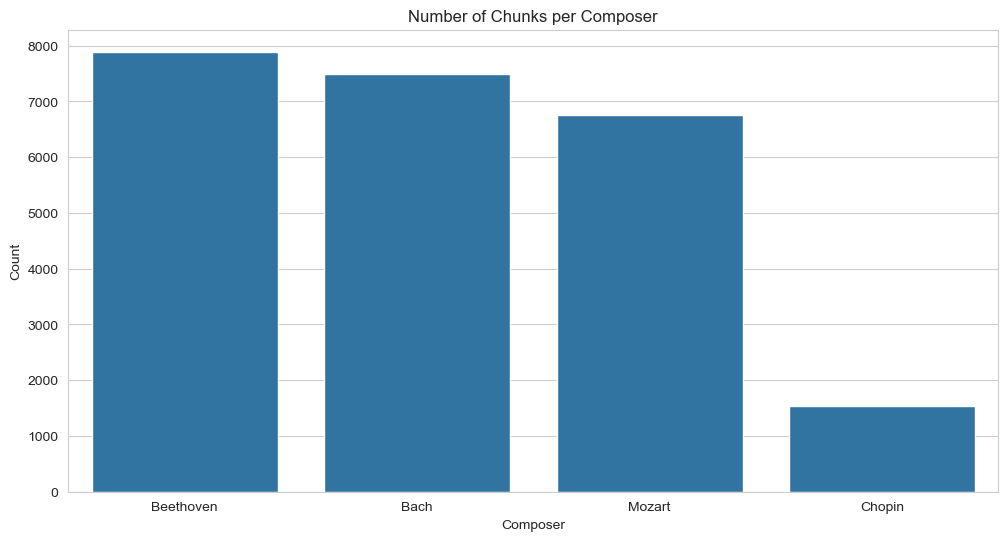

In [14]:
sns.set_style(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Class distribution of selected composers (i.e., 1-Bach, 2-Beethoven, 3-Chopin, 4-Mozart)
composer_counts = midi_df['composer'].value_counts()
sns.barplot(x=composer_counts.index, y=composer_counts.values)
plt.title("Number of Chunks per Composer")
plt.ylabel("Count")
plt.xlabel("Composer")
plt.show()

**Class Distribution :** 

*	Beethoven (~7900 chunks), Bach (~7500), and Mozart (~6800) are well represented.

*	Chopin is underrepresented with fewer than 2000 chunks.

The dataset is imbalanced. Consider stratified sampling or class balancing techniques (e.g., oversampling Chopin or weighted loss functions) before training deep learning models.

In [15]:
# Summary statistics
print("\n🔍 Summary Statistics:")
display(midi_df.describe())


🔍 Summary Statistics:


tempo  num_instruments      duration  note_count     avg_pitch  \
count  23674.000000     23674.000000  23674.000000     23674.0  23674.000000   
mean     203.510935        10.088494     15.112434       200.0     64.097124   
std       32.949589         7.301017     11.021176         0.0      4.132657   
min       52.360524         1.000000      1.160852       200.0     39.020000   
25%      178.292739         4.000000      6.913702       200.0     61.545000   
50%      201.825293         9.000000     12.271593       200.0     64.140000   
75%      229.086014        15.000000     20.531250       200.0     66.735000   
max      291.738193        40.000000    111.422313       200.0     86.420000   

        pitch_range     std_pitch  most_common_pitch  avg_duration  \
count  23674.000000  23674.000000       23674.000000  23674.000000   
mean      48.767466     11.297880          64.852665      0.314680   
std        8.757733      2.264925           9.443440      0.187593   
min       12.000000      2.611436          29.000000      0.053029   
25%       43.000000      9.708415          59.000000      0.188803   
50%       49.000000     11.217458          65.000000      0.259281   
75%       55.000000     12.777904          72.000000      0.384375   
max       79.000000     23.770105          99.000000      2.321600   

       std_duration  note_density  velocity_mean  velocity_std  \
count  23674.000000  23674.000000   23674.000000  23674.000000   
mean       0.311998     22.692132      81.867635      9.154318   
std        0.295860     18.961046      20.890186      7.375413   
min        0.000000      1.794973      15.680000      0.000000   
25%        0.133883      9.741248      65.378750      2.712932   
50%        0.232252     16.297802      81.252500      8.716002   
75%        0.390405     28.928063      97.578750     13.869679   
max        6.943611    172.287249     127.000000     44.614957   

       avg_chord_size  chord_density  
count    23674.000000   23674.000000  
mean         3.719525       6.027244  
std          2.363082       2.602752  
min          1.000000       0.656590  
25%          1.904762       4.123793  
50%          2.985075       5.728636  
75%          4.878049       7.593442  
max         25.000000      19.200008

**Summary Statistics :**

*	Tempo: Mean ~203 BPM, std ~33 --> fairly upbeat tempo across the dataset.

*	Duration: Wide range (min ~1 sec, max ~111 sec), high std (11).

*	Pitch: Average pitch ~64 (E4), with a wide pitch range (up to 79 semitones).

*	Velocity Mean: Avg ~82; shows fairly loud notes.

*	Chord Density: High variability; average around 6 chords per second.

Several features (like note_density, velocity_std, avg_chord_size) show high dispersion and will benefit from normalization before modeling.

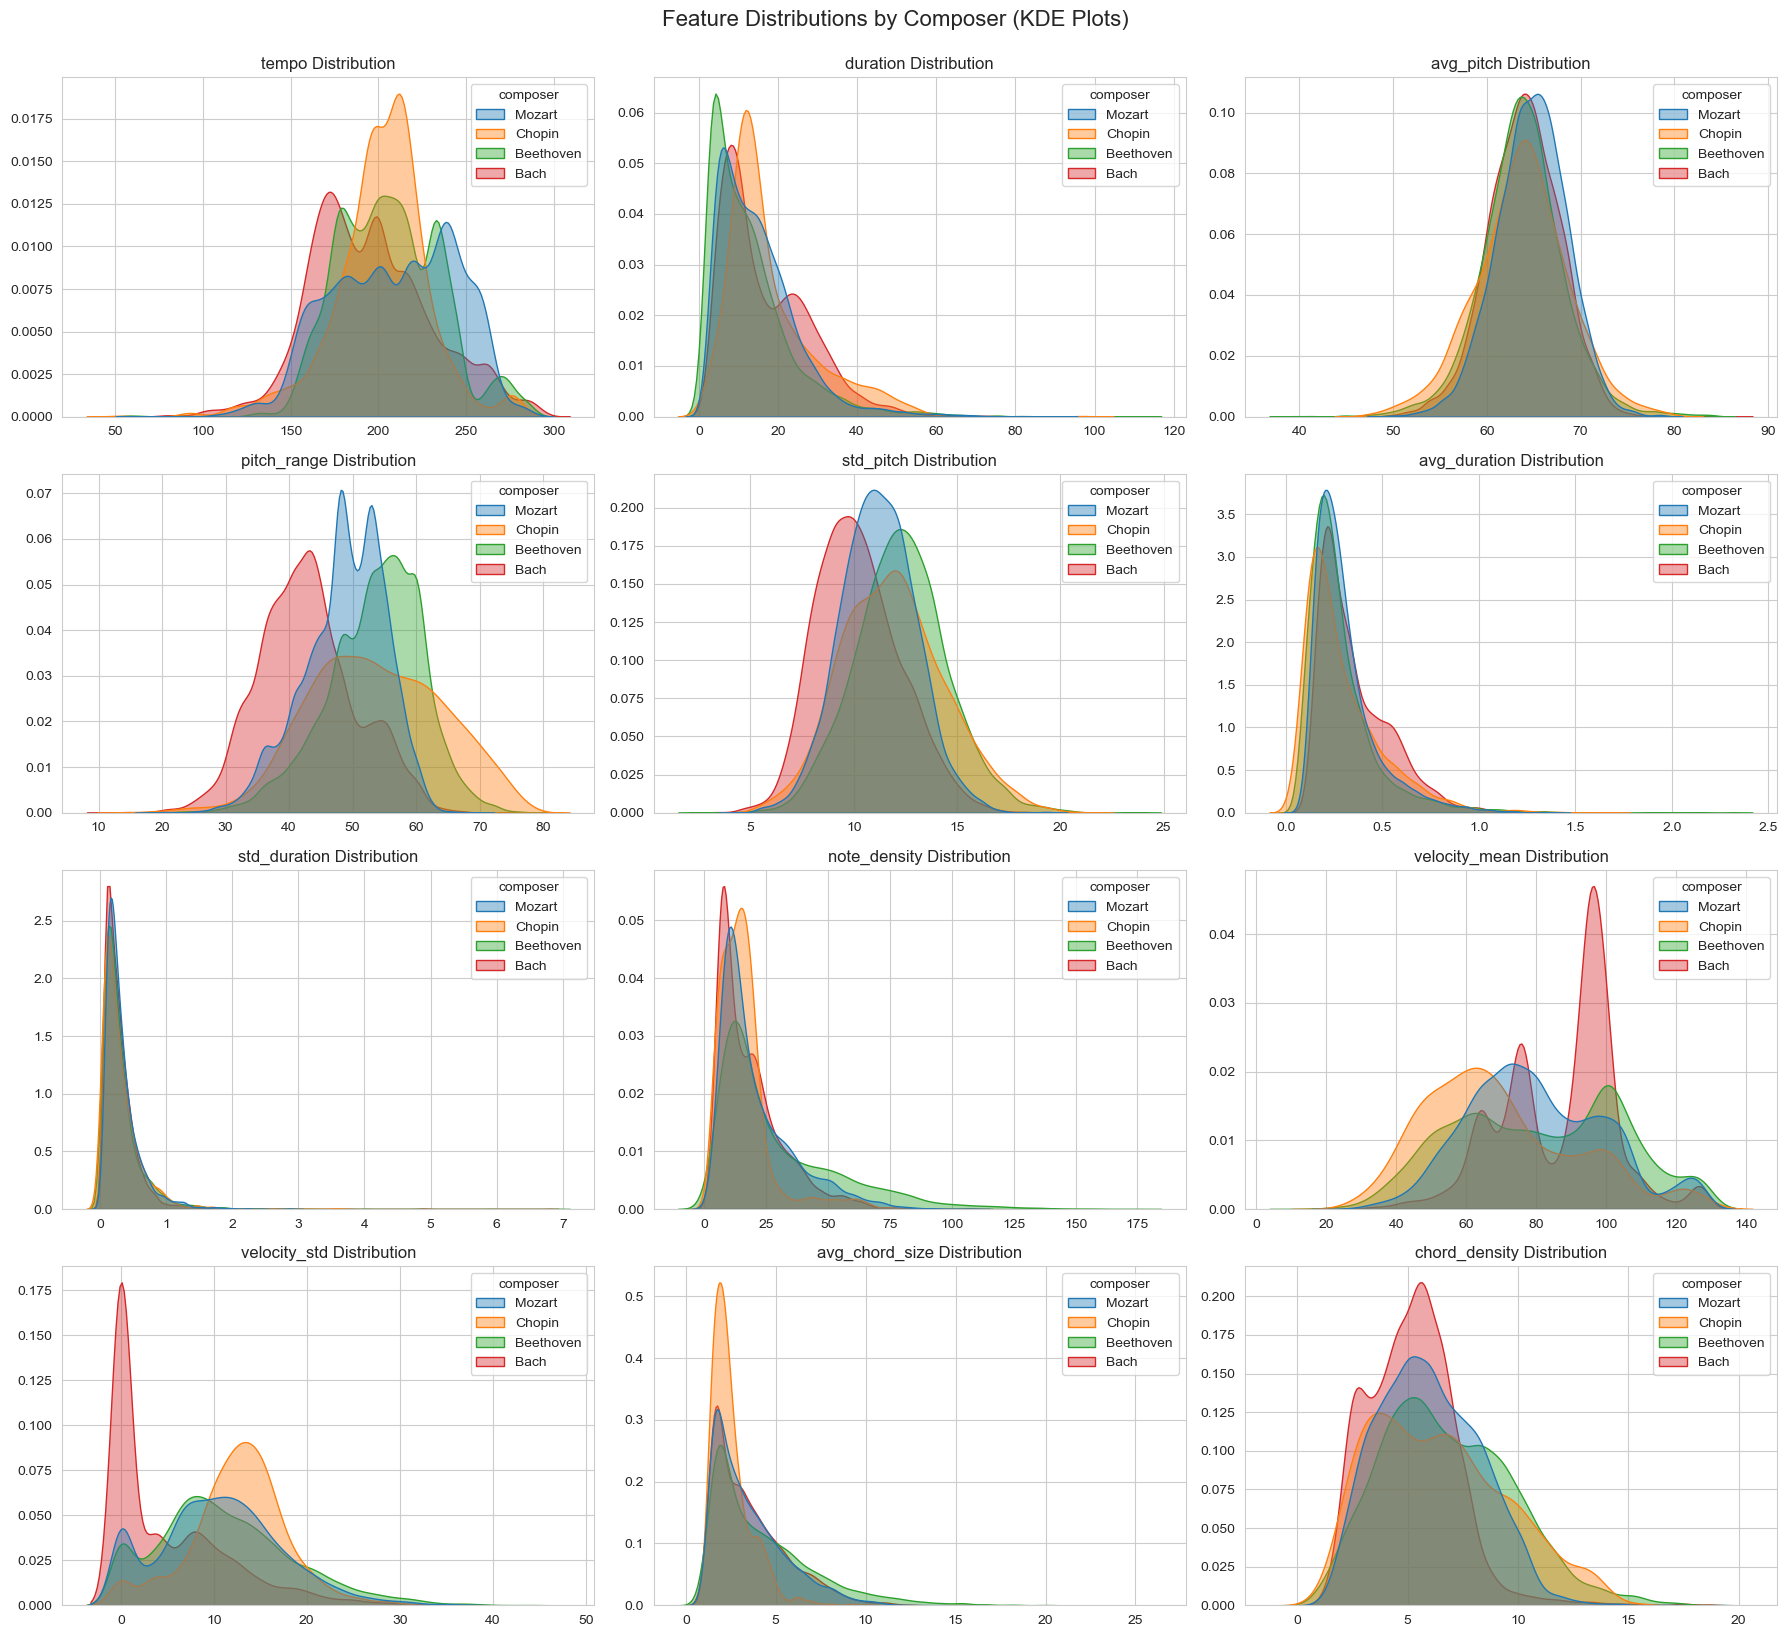

In [16]:
numerical_features = [
    'tempo', 'duration', 'avg_pitch', 'pitch_range', 'std_pitch',
    'avg_duration', 'std_duration', 'note_density', 'velocity_mean', 'velocity_std',
    'avg_chord_size', 'chord_density'
]

# Create subplots (4 rows x 3 columns)
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(numerical_features):
    ax = axes[i]
    sns.kdeplot(
        data=midi_df,
        x=feature,
        hue='composer',
        fill=True,
        common_norm=False,
        alpha=0.4,
        ax=ax
    )
    ax.set_title(f"{feature} Distribution")
    ax.set_xlabel('')
    ax.set_ylabel('')

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.suptitle("Feature Distributions by Composer (KDE Plots)", fontsize=16, y=1.02)
plt.show()

**Feature Distribution using KDE plots :**

Tempo:

*	Mozart and Beethoven are slightly faster than Bach.
*	Chopin’s tempo distribution is more centered.

Pitch Features (avg_pitch, pitch_range, std_pitch):

*	Bach has slightly lower average pitch and pitch range.
*	Chopin exhibits higher variability.

Duration-based features:

*	Chopin has longer avg_duration, std_duration, which aligns with expressive phrasing.

Note/Chord Density:

*	Beethoven’s note/chord density is significantly higher than others — reflects his intense polyphonic writing.

Velocity:

*	Bach has consistently higher velocity_mean (louder dynamics).
*	Chopin has softer dynamics (lower mean, higher variability).

Many features (tempo, pitch range, duration, note density, etc.) are composer-discriminative and should help classification.

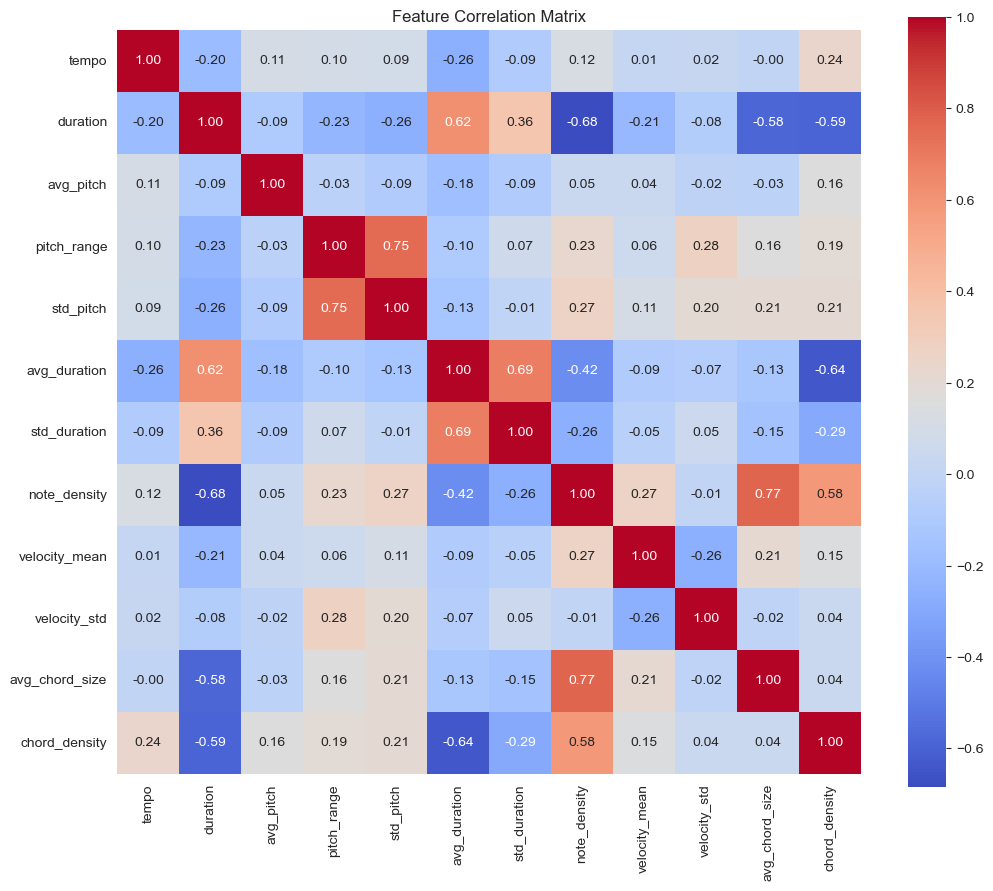

In [17]:
# Correlation heatmap
corr_matrix = midi_df[numerical_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix")
plt.show()

There are no correlated features found from the above correlation matrix.

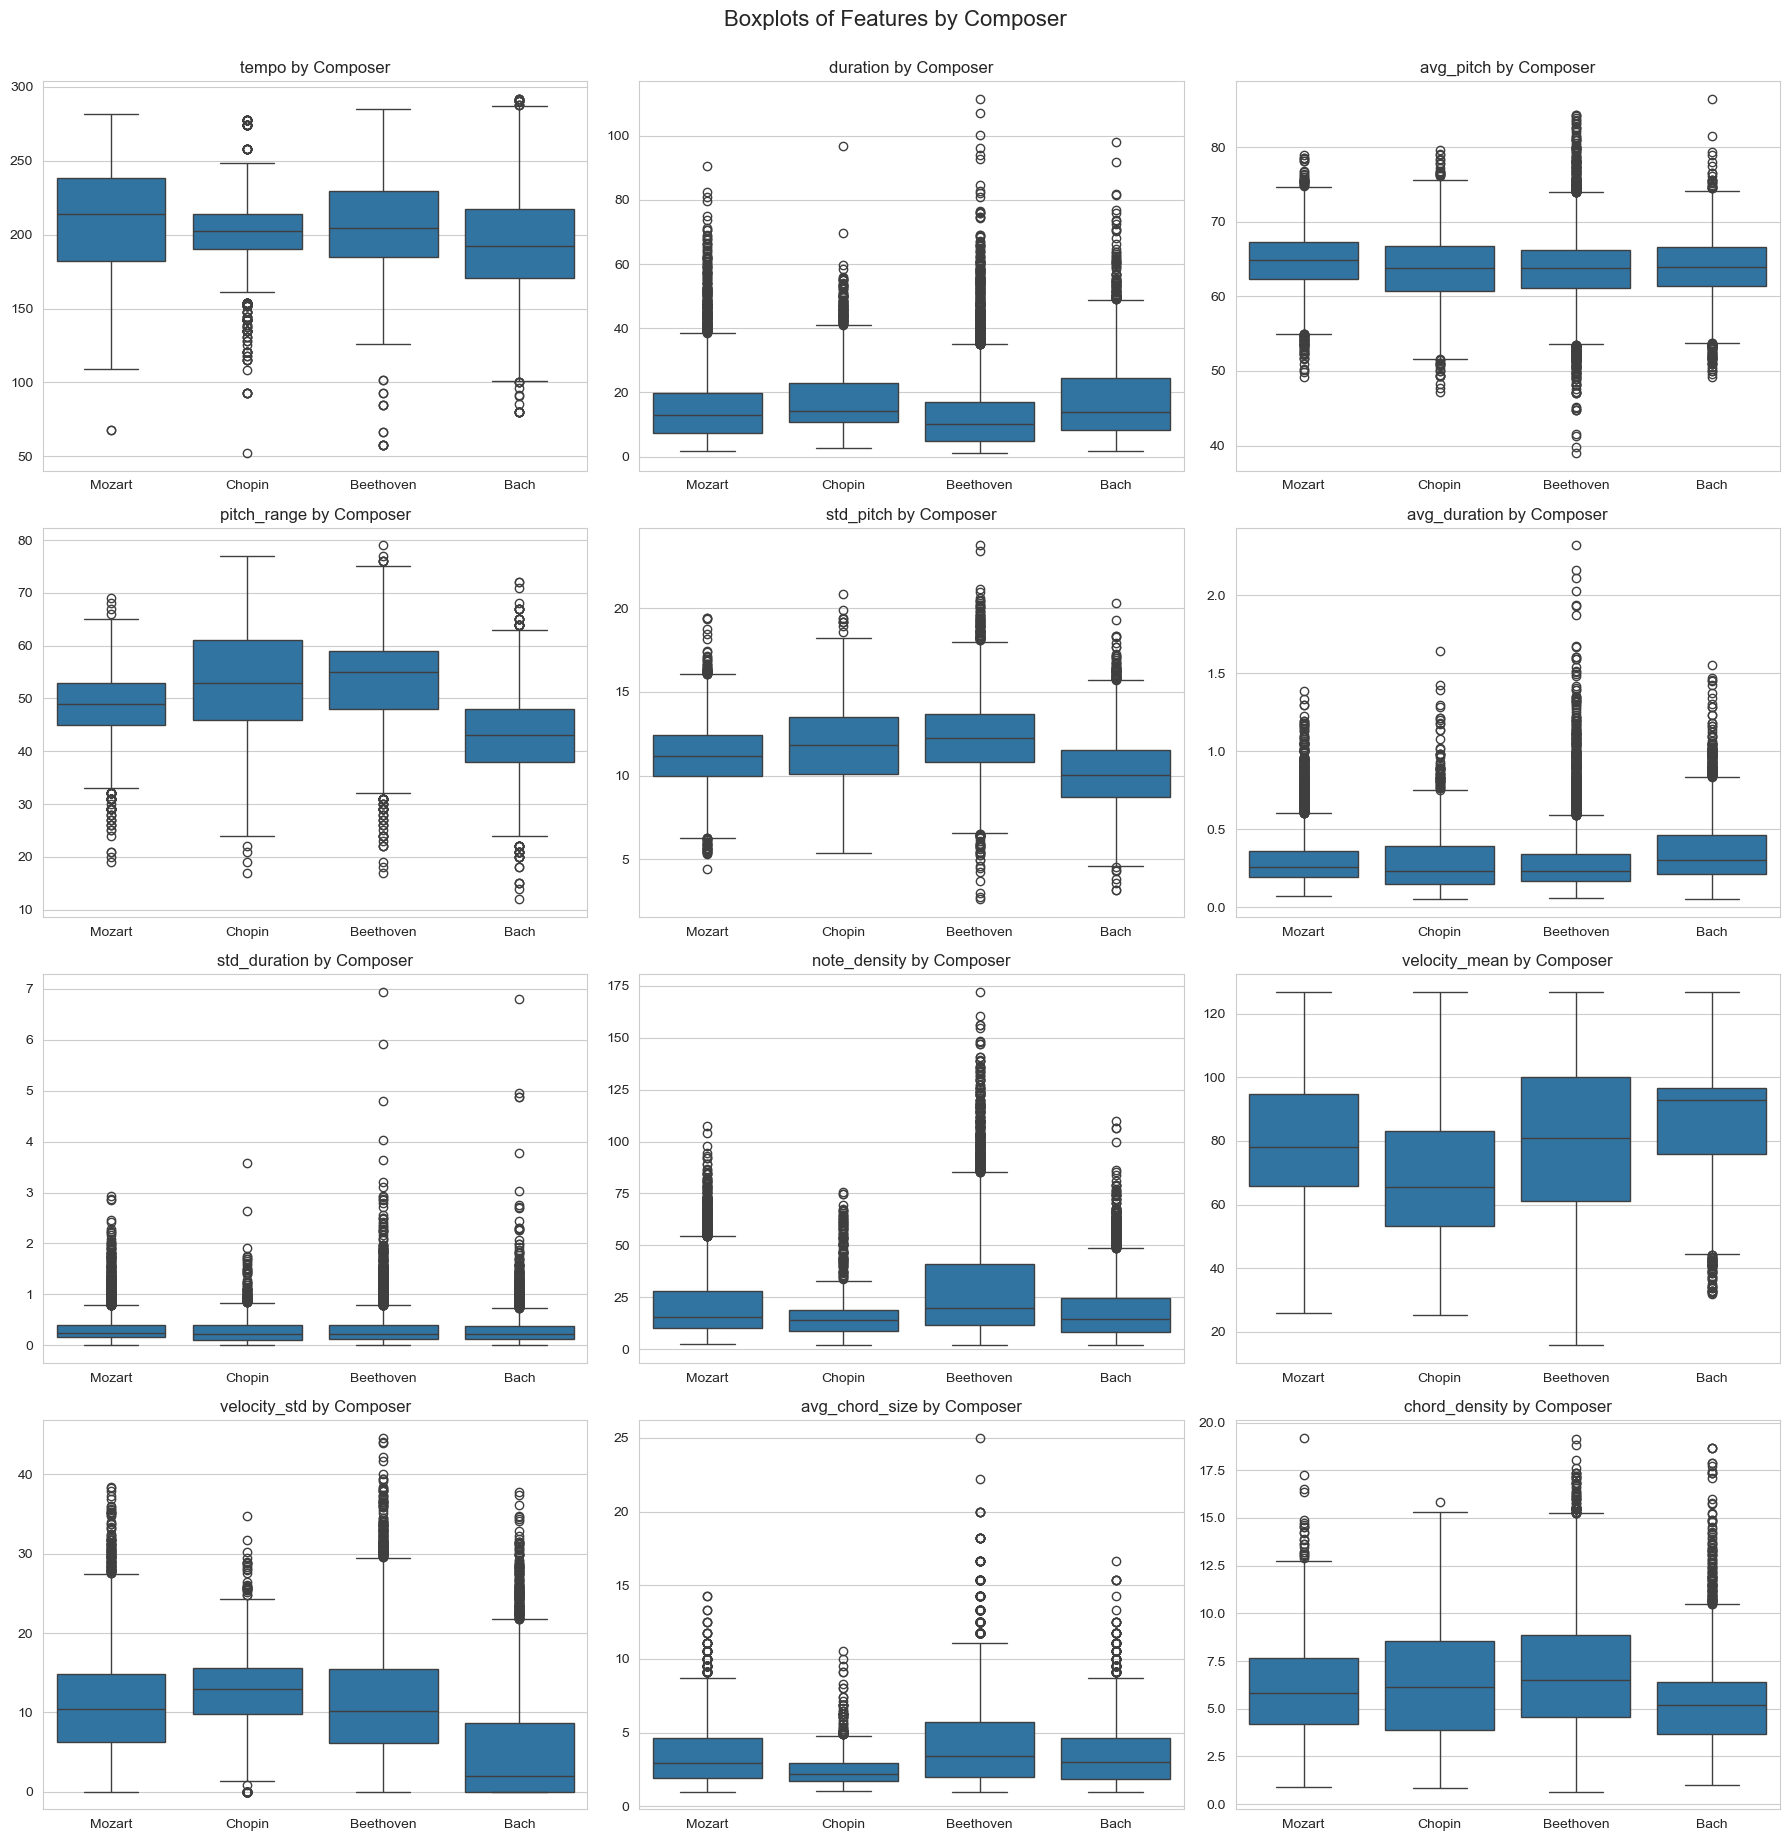

In [18]:
# List of numerical features (same as KDE)
numerical_features = [
    'tempo', 'duration', 'avg_pitch', 'pitch_range', 'std_pitch',
    'avg_duration', 'std_duration', 'note_density', 'velocity_mean', 'velocity_std',
    'avg_chord_size', 'chord_density'
]

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 18))
axes = axes.flatten()

# Generate boxplots
for i, feature in enumerate(numerical_features):
    ax = axes[i]
    sns.boxplot(x='composer', y=feature, data=midi_df, ax=ax)
    ax.set_title(f"{feature} by Composer")
    ax.set_xlabel('')
    ax.set_ylabel('')

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Layout and title
plt.tight_layout()
plt.suptitle("Boxplots of Features by Composer", fontsize=16, y=1.02)
plt.show()

**BoxPlots :**

Observations match KDEs, but now emphasize outliers and spread:

*	Bach and Beethoven have wide spreads in tempo and pitch.
*	Chopin has outliers with very long durations and very soft passages.
*	note_density and velocity_std reveal Beethoven’s richness and complexity in phrasing.

Boxplots reveal high variance and some skew — good justification for using robust or normalized input for LSTM/CNN.



In [19]:
# Outlier detection (example)
from scipy.stats import zscore

z_scores = np.abs(zscore(midi_df[numerical_features]))
outliers = (z_scores > 3).sum(axis=0)
print("\n Potential Outlier Counts per Feature:")
print(pd.Series(outliers, index=numerical_features).sort_values(ascending=False))


 Potential Outlier Counts per Feature:
note_density      449
std_duration      426
avg_duration      402
duration          370
avg_chord_size    361
avg_pitch         206
chord_density     183
velocity_std      138
std_pitch         117
tempo              65
pitch_range        60
velocity_mean       2
dtype: int64


**Outlier Detection (Z-score) :**

Features with most outliers: note_density, std_duration, avg_duration, duration, avg_chord_size

*	May benefit from log-scaling or robust models that tolerate these outliers.
*	Alternatively, clip extreme outliers (e.g., > 99th percentile) to reduce noise in training.

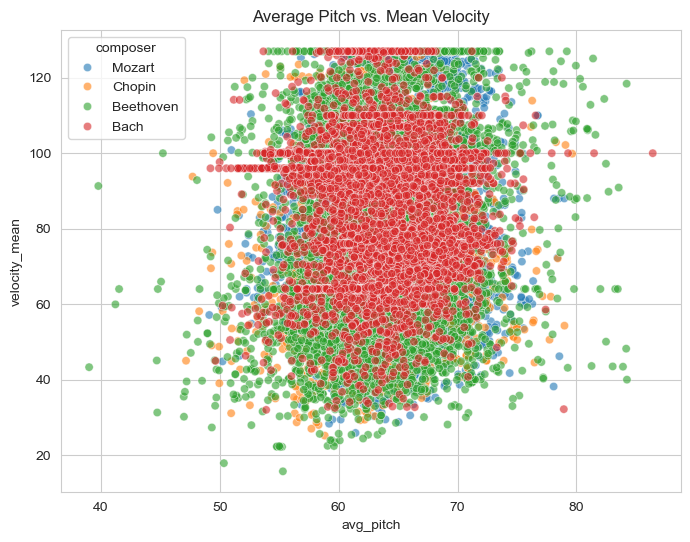

In [20]:
# Velocity vs Pitch
plt.figure(figsize=(8, 6))
sns.scatterplot(data=midi_df, x='avg_pitch', y='velocity_mean', hue='composer', alpha=0.6)
plt.title("Average Pitch vs. Mean Velocity")
plt.show()

**Scatter Plot: Average Pitch vs Mean Velocity :**

*   Most composers cluster tightly between pitch 60–70 and velocity 60–100.

*	However, Bach shows a dense red cluster in the upper-mid velocity range, reinforcing strong dynamic patterns.

*	Overlap makes separation hard using just these two features.

While informative, single 2D relationships aren’t enough — combine features in a model.


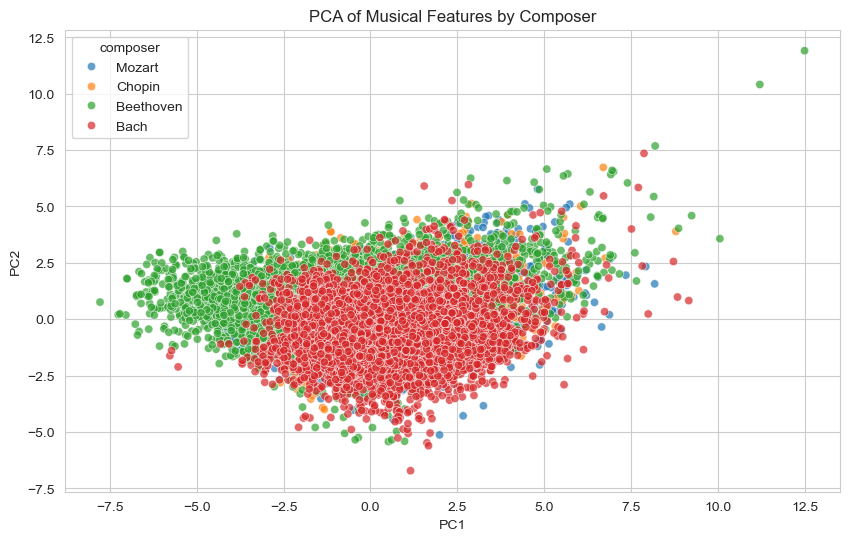

In [21]:
# PCA for 2D visualization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = midi_df[numerical_features]
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
pca_df['composer'] = midi_df['composer']

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='composer', alpha=0.7)
plt.title("PCA of Musical Features by Composer")
plt.show()

**PCA 2D projection of all features :**

Some visible clustering by composer, especially:

*	Bach and Beethoven overlap heavily but form their own centers.

*	Chopin is slightly more dispersed.

*	Mozart is scattered in between.

Features do contain signal useful for composer classification.

A non-linear model (e.g., LSTM or CNN) will likely separate classes better than linear ones.

## Implementation Plan Based on EDA Observations

#### ***1. Data Preprocessing***

*	Handle Class Imbalance: 

The dataset is imbalanced, with significantly fewer samples for Chopin compared to Bach, Beethoven, and Mozart. To address this, we recommend using class weights during model training or applying oversampling techniques like SMOTE to ensure the model is not biased toward the dominant classes.

*	Feature Standardization: 

The EDA revealed wide variation in the scale of features such as tempo, duration, and note_density. These features need to be standardized using a technique like StandardScaler to ensure that all input variables contribute equally during model training.

*	Outlier Handling: 

Features such as note_density, avg_duration, std_duration, and avg_chord_size showed extreme outliers. These can be capped using quantile-based clipping (e.g., clipping values above the 99th percentile) or handled using robust scaling methods to minimize their impact on training.


#### ***2. Feature Selection:***

*	Use All Extracted Features:

The 12 extracted numerical features—such as avg_pitch, pitch_range, velocity_mean, and chord_density—showed meaningful variation across composers in the KDE and box plots. All these features should be retained as they are likely to contribute valuable information for composer classification.

*	No Feature Binning:

All features should remain continuous; no binning or discretization is required, as this could reduce the expressive power of the input data.

####  ***3. Dataset Splitting:***

*	Stratified Train-Test Split:

To maintain class proportions across training and test sets, stratified sampling should be used when splitting the dataset. This ensures fair evaluation across all composers.

*	Label Encoding:

The composer names (Bach, Beethoven, Chopin, Mozart) should be encoded using LabelEncoder to convert categorical labels into numerical class indices for model training.

#### ***4. Model Input Preparation :***

*	LSTM Input Formatting:

Since LSTM expects 3D input (samples, time steps, features), the feature matrix should be reshaped to (samples, 1, 12), treating each 200-note chunk as a single time step with 12 features.

*	CNN Input Formatting:

For 1D CNNs, reshape the feature matrix to (samples, 12, 1) to treat each chunk’s features as a spatial sequence. This allows convolutional filters to detect local feature patterns.

#### ***5. Model Development :***


*	LSTM Model Architecture:

Use an LSTM-based architecture with an input layer followed by an LSTM layer, a dropout layer to reduce overfitting, a dense hidden layer, and a softmax output layer for multiclass classification. LSTM can capture temporal dependencies if you later decide to incorporate note-level sequences.

*	CNN Model Architecture:

A 1D CNN can be built using a Conv1D layer followed by a pooling layer, dropout, and dense layers. This model excels at capturing localized feature interactions and performs well on structured numerical data like this.

#### ***6. Model Training :***

*	Loss and Optimization:

Use sparse_categorical_crossentropy as the loss function since the output is a multiclass label. The Adam optimizer is recommended for efficient training.


*	Regularization and Callbacks:

Implement EarlyStopping to halt training if the validation loss doesn’t improve for a few epochs, and ReduceLROnPlateau to dynamically lower the learning rate during plateaus. These help prevent overfitting and speed up convergence.


#### ***7. Model Evaluation :***

*	Performance Metrics:

Evaluate the model using accuracy, precision, recall, and F1-score. These metrics offer a comprehensive view of model effectiveness, especially in imbalanced datasets.

*	Confusion Matrix Analysis:

Plot a confusion matrix to identify specific class-wise misclassifications. For example, observe if the model confuses Bach with Beethoven more frequently, and adjust training strategies accordingly.


#### ***8. Optional Advanced Enhancements :***

*	Dimensionality Reduction:

Apply PCA or t-SNE to visualize the latent structure of the dataset. This can help validate feature clustering and inform architectural decisions.

*	Attention Mechanisms:

Introduce attention layers in the LSTM model to allow the network to focus on the most informative parts of the sequence, improving both performance and interpretability.

*	Explainability Tools:

Use SHAP or LIME to understand the contribution of each feature to model predictions. This can provide insights into which musical characteristics are most important for composer identification.



### Data Cleaning and Preprocessing

In [22]:
# Encode target labels (composer)
label_encoder = LabelEncoder()
midi_df['composer_encoded'] = label_encoder.fit_transform(midi_df['composer'])

In [23]:
# Split dataset into features and labels
X = midi_df[numerical_features]
y = midi_df['composer_encoded']

In [24]:
# Train/Validation/Test split (e.g., 70/15/15)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

In [25]:
print("Before upsampling:", Counter(y_train))

Before upsampling: Counter({1: 5523, 0: 5245, 3: 4731, 2: 1071})


In [26]:
# 4. Upsample the minority class in training set
train_df = pd.concat([X_train, y_train], axis=1)
max_count = train_df['composer_encoded'].value_counts().max()

In [33]:
# Upsample each class to match the max count
upsampled_train = (
    train_df.set_index('composer_encoded')
    .groupby(level=0, group_keys=False)
    .apply(lambda x: x.sample(max_count, replace=True, random_state=42))
    .reset_index()
)

In [34]:
# Split upsampled back into X and y
X_train_upsampled = upsampled_train[numerical_features]
y_train_upsampled = upsampled_train['composer_encoded']

print("After upsampling:", Counter(y_train_upsampled))

After upsampling: Counter({0: 5523, 1: 5523, 2: 5523, 3: 5523})


### LSTM Input preparation

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale features (fit only on upsampled training data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_upsampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays to LSTM-compatible shape: (samples, timesteps=1, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_lstm = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Convert labels to NumPy arrays
y_train_np = y_train_upsampled.values
y_val_np = y_val.values
y_test_np = y_test.values

# Confirm shapes
print("LSTM Input Shapes:")
print(f"X_train: {X_train_lstm.shape}, y_train: {y_train_np.shape}")
print(f"X_val:   {X_val_lstm.shape}, y_val:   {y_val_np.shape}")
print(f"X_test:  {X_test_lstm.shape}, y_test:  {y_test_np.shape}")

LSTM Input Shapes:
X_train: (22092, 1, 12), y_train: (22092,)
X_val:   (3552, 1, 12), y_val:   (3552,)
X_test:  (3552, 1, 12), y_test:  (3552,)


In [32]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir="  # clear CUDA libdevice path
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # ensure GPU is used (optional)

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices("GPU"))

TensorFlow version: 2.18.0
GPU devices: []


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense

print(Sequential)

<class 'keras.src.models.sequential.Sequential'>


### Generating Grid Search Parameter Combinations for LSTM

In [34]:
from itertools import product

# Define grid
param_grid = {
    'lstm_units': [32, 64],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [32, 64]
}

# Generate all combinations
param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

print(f"Total combinations: {len(param_combinations)}")

Total combinations: 8


In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=0
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=0
)

In [ ]:
# trains an LSTM model for each grid search combination, and logs accuracy/loss so you can later choose the best configuration.
results = []

for combo in param_combinations:
    params = dict(zip(param_names, combo))
    print(f"Training with: {params}")

    # Build model
    model = Sequential([
        Input(shape=(1, X_train_lstm.shape[2])),
        LSTM(params['lstm_units'], return_sequences=False),
        Dropout(params['dropout_rate']),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Fit model (no verbose)
    history = model.fit(
        X_train_lstm, y_train_np,
        epochs=30,
        batch_size=params['batch_size'],
        validation_data=(X_val_lstm, y_val_np),
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    # Evaluate on validation set
    val_loss, val_accuracy = model.evaluate(X_val_lstm, y_val_np, verbose=0)

    # Store results
    results.append({
        'lstm_units': params['lstm_units'],
        'dropout_rate': params['dropout_rate'],
        'batch_size': params['batch_size'],
        'val_accuracy': val_accuracy,
        'val_loss': val_loss,
        'history': history.history
    })

Training with: {'lstm_units': 32, 'dropout_rate': 0.2, 'batch_size': 32}
Training with: {'lstm_units': 32, 'dropout_rate': 0.2, 'batch_size': 64}
Training with: {'lstm_units': 32, 'dropout_rate': 0.3, 'batch_size': 32}
Training with: {'lstm_units': 32, 'dropout_rate': 0.3, 'batch_size': 64}
Training with: {'lstm_units': 64, 'dropout_rate': 0.2, 'batch_size': 32}
Training with: {'lstm_units': 64, 'dropout_rate': 0.2, 'batch_size': 64}
Training with: {'lstm_units': 64, 'dropout_rate': 0.3, 'batch_size': 32}
Training with: {'lstm_units': 64, 'dropout_rate': 0.3, 'batch_size': 64}


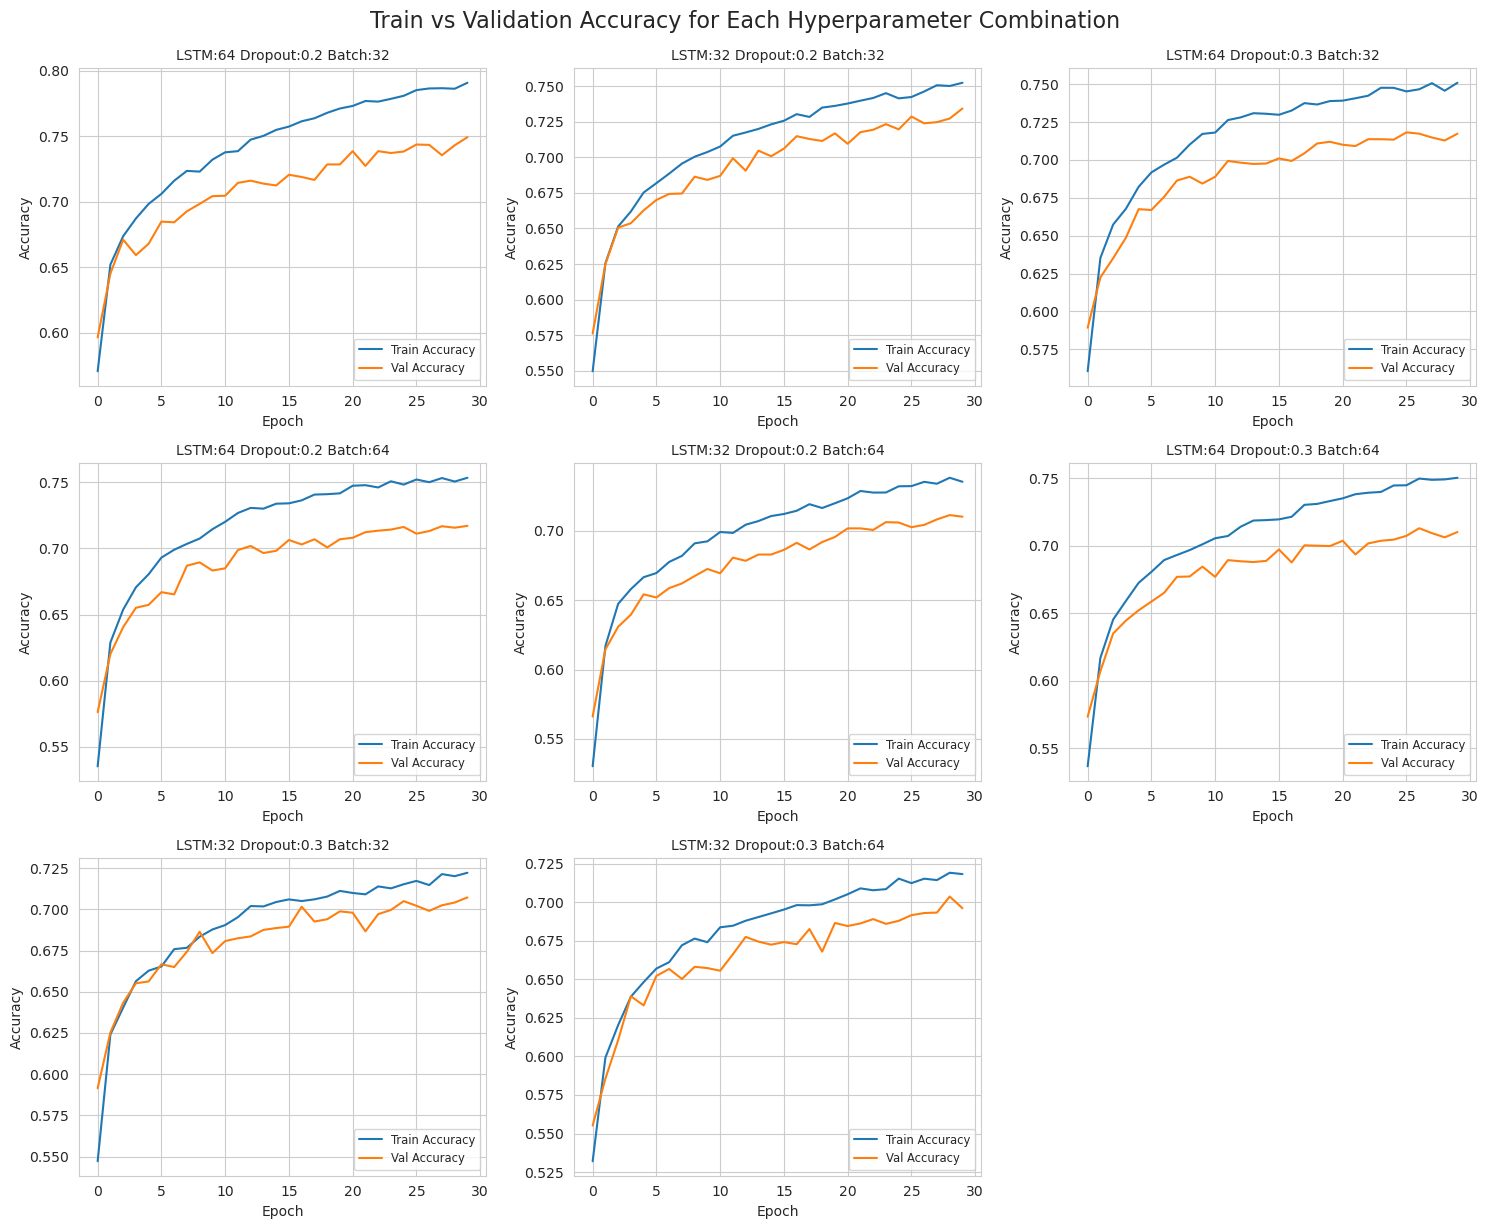

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Sort results by validation accuracy
sorted_results = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)

# Define subplot grid layout
num_plots = len(sorted_results)
cols = 3  # You can change to 4 if preferred
rows = math.ceil(num_plots / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()  # Flatten in case of multiple rows

# Plot each combination
for i, res in enumerate(sorted_results):
    ax = axes[i]
    label = f"LSTM:{res['lstm_units']} Dropout:{res['dropout_rate']} Batch:{res['batch_size']}"
    
    ax.plot(res['history']['accuracy'], label='Train Accuracy')
    ax.plot(res['history']['val_accuracy'], label='Val Accuracy')
    ax.set_title(label, fontsize=10)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.legend(loc='lower right', fontsize='small')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Train vs Validation Accuracy for Each Hyperparameter Combination", fontsize=16, y=1.02)
plt.show()

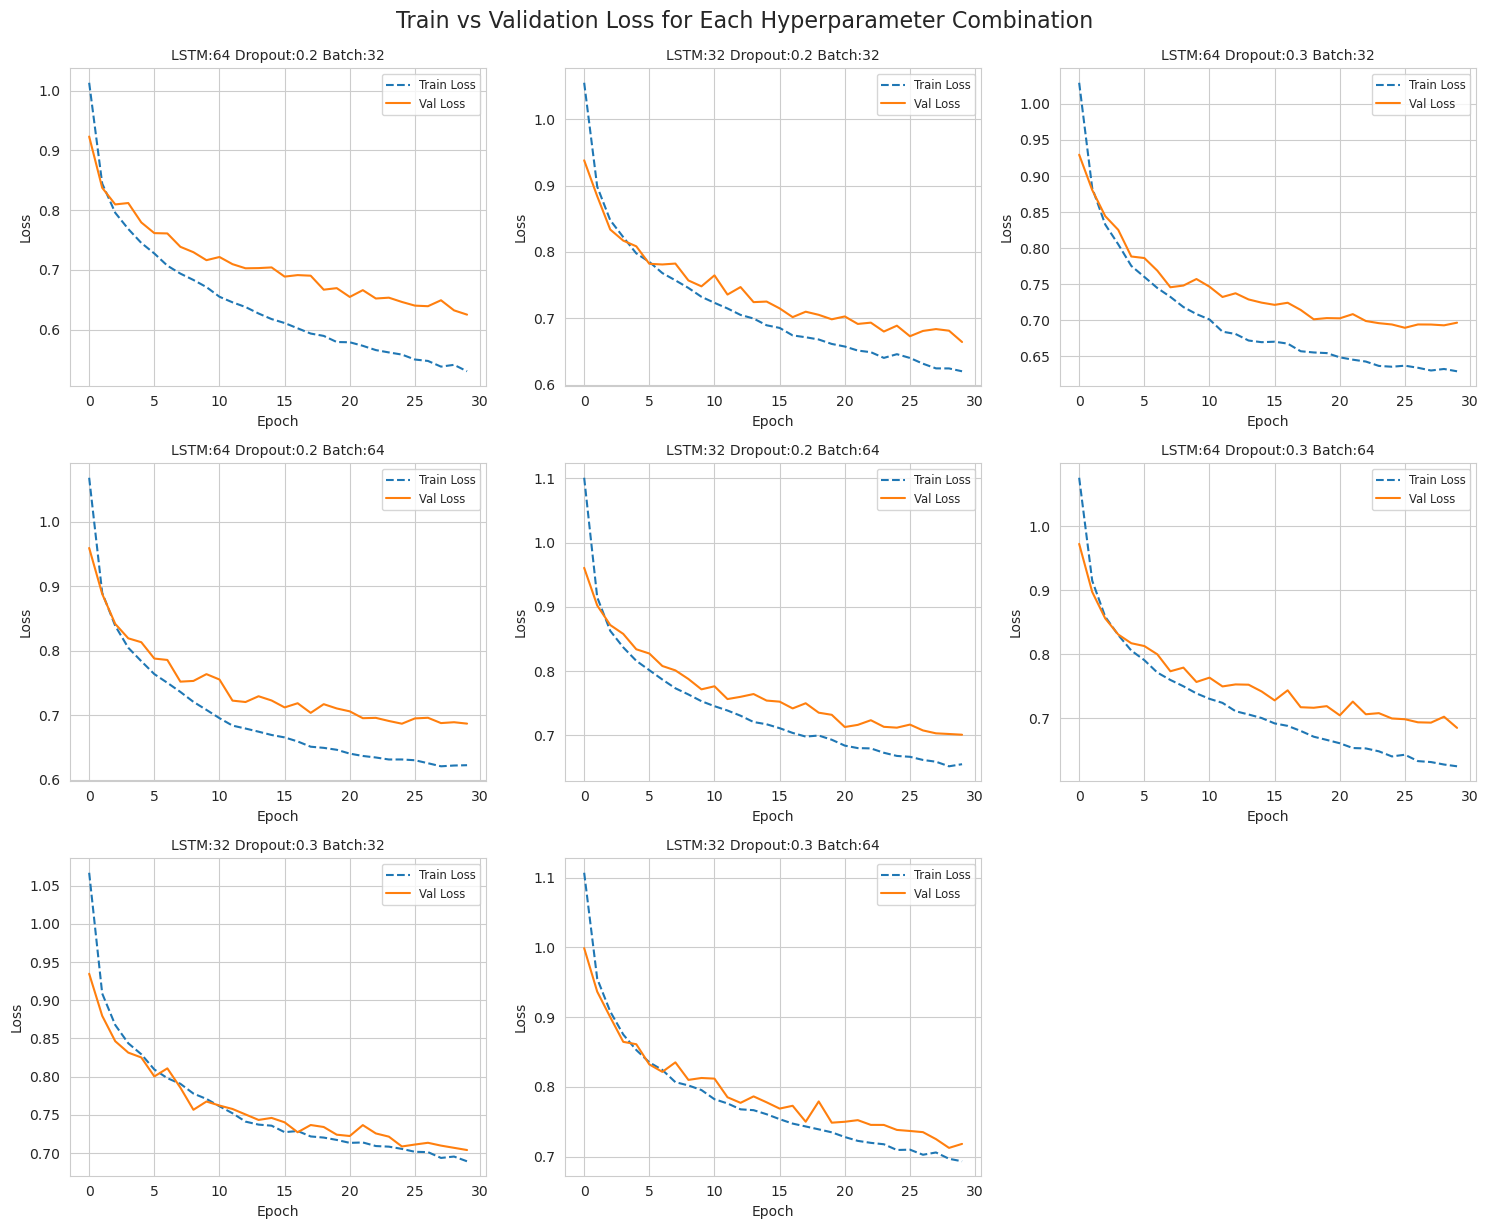

In [41]:
import matplotlib.pyplot as plt
import math

# Sort results by validation accuracy
sorted_results = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)

# Define subplot layout
num_plots = len(sorted_results)
cols = 3  # You can change to 4 if you prefer 4 plots per row
rows = math.ceil(num_plots / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

# Plot loss curves for each combination
for i, res in enumerate(sorted_results):
    ax = axes[i]
    label = f"LSTM:{res['lstm_units']} Dropout:{res['dropout_rate']} Batch:{res['batch_size']}"
    
    ax.plot(res['history']['loss'], linestyle='--', label='Train Loss')
    ax.plot(res['history']['val_loss'], label='Val Loss')
    ax.set_title(label, fontsize=10)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend(loc='upper right', fontsize='small')

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Train vs Validation Loss for Each Hyperparameter Combination", fontsize=16, y=1.02)
plt.show()

In [42]:
best_model = sorted_results[0]
print("\n Best Model Configuration:")
print(f"LSTM Units: {best_model['lstm_units']}")
print(f"Dropout Rate: {best_model['dropout_rate']}")
print(f"Batch Size: {best_model['batch_size']}")
print(f"Validation Accuracy: {best_model['val_accuracy']:.4f}")


 Best Model Configuration:
LSTM Units: 64
Dropout Rate: 0.2
Batch Size: 32
Validation Accuracy: 0.7494


In [ ]:
# Now retrain the LSTM model on best parameters found from grid search
model = Sequential([
    Input(shape=(1, X_train_lstm.shape[2])),  # (timesteps=1, features)
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 64)             │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,924 (85.64 KB)

 Trainable params: 21,924 (85.64 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# # Set Up Callbacks
early_stop = EarlyStopping(
     monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
 )

reduce_lr = ReduceLROnPlateau(
     monitor='val_loss', factor=0.5, patience=3, verbose=1
 )

In [45]:
history = model.fit(
    X_train_lstm, y_train_np,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_lstm, y_val_np),
    callbacks=[early_stop, reduce_lr],
    verbose=0  # supress the epoch logs
)


Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 32.


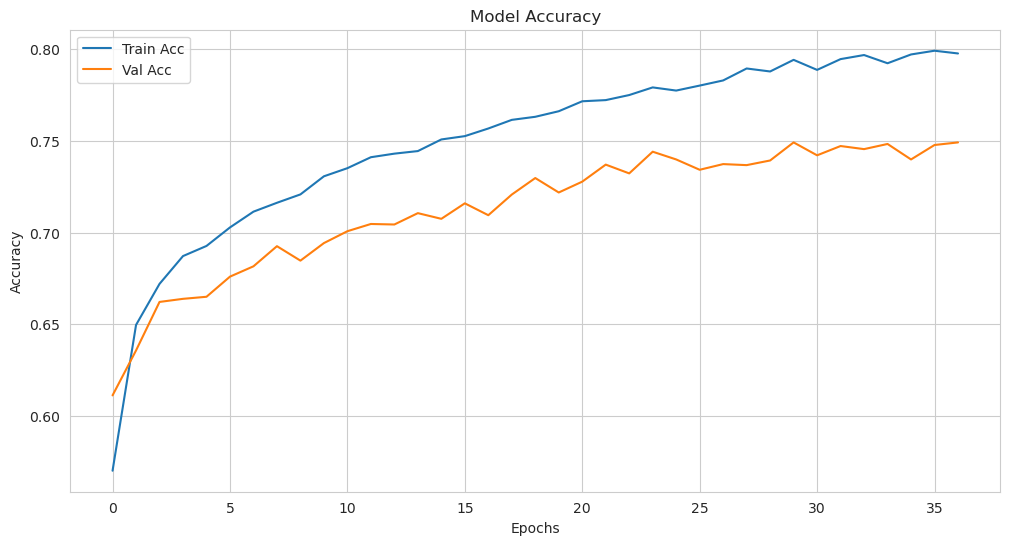

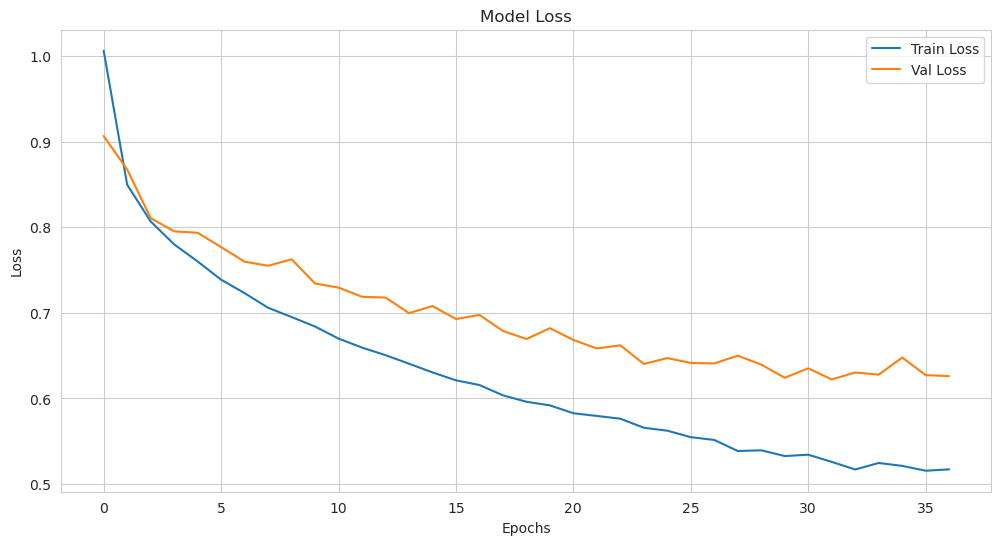

In [46]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [47]:
# Predict on test set
y_pred = model.predict(X_test_lstm).argmax(axis=1)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_test_np, y_pred, target_names=label_encoder.classes_))

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

        Bach       0.87      0.84      0.85      1124
   Beethoven       0.80      0.64      0.71      1184
      Chopin       0.47      0.82      0.59       230
      Mozart       0.68      0.75      0.72      1014

    accuracy                           0.75      3552
   macro avg       0.70      0.76      0.72      3552
weighted avg       0.77      0.75      0.75      3552



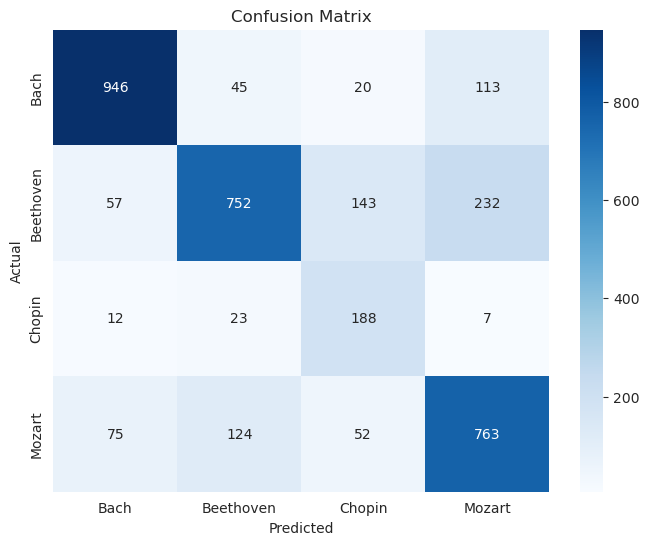

In [48]:
import seaborn as sns

cm = confusion_matrix(y_test_np, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [50]:
model.save("composer_lstm_model.keras")  # saves as .keras format

### LSTM Model Evaluation Summary

| Parameter       | Value  |
|----------------|--------|
| LSTM Units     | 64     |
| Dropout Rate   | 0.2    |
| Batch Size     | 32     |
| Epochs         | 50     |
| Validation Accuracy | **0.7494** |

| Composer   | Precision | Recall | F1-Score | Support |
|------------|-----------|--------|----------|---------|
| Bach       | 0.87      | 0.84   | 0.85     | 1124    |
| Beethoven  | 0.80      | 0.64   | 0.71     | 1184    |
| Chopin     | 0.47      | 0.82   | 0.59     | 230     |
| Mozart     | 0.68      | 0.75   | 0.72     | 1014    |
| **Accuracy**   |           |        | **0.75**     | 3552    |
| Macro Avg  | 0.70      | 0.76   | 0.72     |         |
| Weighted Avg | 0.77    | 0.75   | 0.75     |         |

### Insights:

1.	Overall Performance:
*	The model achieved a solid accuracy of 75% on the test set, indicating strong generalization performance after tuning.
2.	Per-Class Insights:
*	Bach had the highest precision and F1-score, showing that the model identifies his style quite effectively.
*	Chopin had high recall (0.82) but low precision (0.47), meaning the model predicted Chopin often but with many false positives.
*	Beethoven’s recall is lower (0.64), suggesting some of his pieces are getting confused with others—possibly Mozart due to stylistic similarities.
3.	Model Behavior:
*	The confusion matrix shows Chopin is often misclassified, which may stem from:
*	Underrepresentation in training data.
*	Less distinctive temporal/chordal features in the chunked format.
*	Higher stylistic overlap with Mozart or Beethoven.
4.	Loss Curves:
*	Training and validation losses show steady convergence across most parameter sets, with no severe overfitting or underfitting.
*	Grid search visualizations confirm that the selected hyperparameters strike a good trade-off between performance and stability.

### Conclusion

•	The LSTM model, after grid search tuning, delivered robust classification performance, especially for Bach and Mozart.
•	Chopin remains a challenging class due to either data limitations or feature ambiguity.
•	The model shows potential for further improvement via:
•	Incorporating bidirectional LSTM with attention (which you already implemented next),
•	Using more expressive features (e.g., harmonic intervals, rhythmic patterns),
•	Or applying data augmentation to balance composer representation.

## CNN Implementation

In [18]:
# Load the featured dataset into datafrme for CNN
df_cnn = pd.read_csv('chunked_midi_features.csv')

In [19]:
df_cnn.shape

(23674, 18)

In [20]:
df_cnn.head()

split composer                        filename       tempo  \
0  train   Mozart  K495 Horn Concerto n4 1mov.mid  218.736624   
1  train   Mozart  K495 Horn Concerto n4 1mov.mid  218.736624   
2  train   Mozart  K495 Horn Concerto n4 1mov.mid  218.736624   
3  train   Mozart  K495 Horn Concerto n4 1mov.mid  218.736624   
4  train   Mozart  K495 Horn Concerto n4 1mov.mid  218.736624   

   num_instruments   duration  note_count  avg_pitch  pitch_range  std_pitch  \
0                8   8.749994         200     63.725           50  11.842693   
1                8   8.965511         200     65.105           52  13.510143   
2                8   5.646548         200     66.345           48  11.992747   
3                8  12.672405         200     59.035           50  11.767063   
4                8   8.103442         200     61.420           45  12.572335   

   most_common_pitch  avg_duration  std_duration  note_density  velocity_mean  \
0                 63      0.411638      0.734632     22.857160         78.975   
1                 63      0.281573      0.273440     22.307709         78.025   
2                 79      0.198976      0.107201     35.419873         79.910   
3                 58      0.501778      1.127466     15.782324         67.760   
4                 51      0.248599      0.301126     24.680869         75.110   

   velocity_std  avg_chord_size  chord_density  
0     13.685554        4.166667       5.485718  
1     12.948914        4.000000       5.576927  
2     11.811939        4.651163       7.615273  
3      8.986790        3.846154       4.103404  
4     10.999450        3.448276       7.157452

In [21]:
df_cnn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23674 entries, 0 to 23673
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   split              23674 non-null  object 
 1   composer           23674 non-null  object 
 2   filename           23674 non-null  object 
 3   tempo              23674 non-null  float64
 4   num_instruments    23674 non-null  int64  
 5   duration           23674 non-null  float64
 6   note_count         23674 non-null  int64  
 7   avg_pitch          23674 non-null  float64
 8   pitch_range        23674 non-null  int64  
 9   std_pitch          23674 non-null  float64
 10  most_common_pitch  23674 non-null  int64  
 11  avg_duration       23674 non-null  float64
 12  std_duration       23674 non-null  float64
 13  note_density       23674 non-null  float64
 14  velocity_mean      23674 non-null  float64
 15  velocity_std       23674 non-null  float64
 16  avg_chord_size     236

In [22]:
df_cnn.describe()

tempo  num_instruments      duration  note_count     avg_pitch  \
count  23674.000000     23674.000000  23674.000000     23674.0  23674.000000   
mean     203.510935        10.088494     15.112434       200.0     64.097124   
std       32.949589         7.301017     11.021176         0.0      4.132657   
min       52.360524         1.000000      1.160852       200.0     39.020000   
25%      178.292739         4.000000      6.913702       200.0     61.545000   
50%      201.825293         9.000000     12.271593       200.0     64.140000   
75%      229.086014        15.000000     20.531250       200.0     66.735000   
max      291.738193        40.000000    111.422313       200.0     86.420000   

        pitch_range     std_pitch  most_common_pitch  avg_duration  \
count  23674.000000  23674.000000       23674.000000  23674.000000   
mean      48.767466     11.297880          64.852665      0.314680   
std        8.757733      2.264925           9.443440      0.187593   
min       12.000000      2.611436          29.000000      0.053029   
25%       43.000000      9.708415          59.000000      0.188803   
50%       49.000000     11.217458          65.000000      0.259281   
75%       55.000000     12.777904          72.000000      0.384375   
max       79.000000     23.770105          99.000000      2.321600   

       std_duration  note_density  velocity_mean  velocity_std  \
count  23674.000000  23674.000000   23674.000000  23674.000000   
mean       0.311998     22.692132      81.867635      9.154318   
std        0.295860     18.961046      20.890186      7.375413   
min        0.000000      1.794973      15.680000      0.000000   
25%        0.133883      9.741248      65.378750      2.712932   
50%        0.232252     16.297802      81.252500      8.716002   
75%        0.390405     28.928063      97.578750     13.869679   
max        6.943611    172.287249     127.000000     44.614957   

       avg_chord_size  chord_density  
count    23674.000000   23674.000000  
mean         3.719525       6.027244  
std          2.363082       2.602752  
min          1.000000       0.656590  
25%          1.904762       4.123793  
50%          2.985075       5.728636  
75%          4.878049       7.593442  
max         25.000000      19.200008

In [23]:
# Encode target labels (composer)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_cnn['composer_encoded'] = label_encoder.fit_transform(df_cnn['composer'])

In [24]:
# Frequency encode the 'most_common_pitch' column
pitch_freq = df_cnn['most_common_pitch'].value_counts(normalize=True)
df_cnn['most_common_pitch_freq'] = df_cnn['most_common_pitch'].map(pitch_freq)

df_cnn.drop(columns=['most_common_pitch'], inplace=True)

In [25]:
# Split dataset into features and labels
numerical_features = [
    'tempo', 'duration', 'avg_pitch', 'pitch_range', 'std_pitch',
    'avg_duration', 'std_duration', 'note_density', 'velocity_mean', 'velocity_std',
    'avg_chord_size', 'chord_density', 'most_common_pitch_freq'
]
X_cnn = df_cnn[numerical_features]
y_cnn = df_cnn['composer_encoded']

In [26]:
# Train/Validation/Test split (e.g., 70/15/15)
X_cnn_temp, X_cnn_test, y_cnn_temp, y_cnn_test = train_test_split(X_cnn, y_cnn, test_size=0.15, stratify=y_cnn, random_state=42)
X_cnn_train, X_cnn_val, y_cnn_train, y_cnn_val = train_test_split(X_cnn_temp, y_cnn_temp, test_size=0.1765, stratify=y_cnn_temp, random_state=42)

In [27]:
# counts before upsampling
print("Before upsampling:", Counter(y_cnn_train))

Before upsampling: Counter({1: 5523, 0: 5245, 3: 4731, 2: 1071})


In [28]:
# Upsample the minority class in training set
train_df_cnn= pd.concat([X_cnn_train, y_cnn_train], axis=1)
max_count = train_df_cnn['composer_encoded'].value_counts().max()

In [32]:
# Upsample each class to match the max count
upsampled_train_cnn = (
    train_df_cnn.set_index('composer_encoded')
    .groupby(level=0, group_keys=False)
    .apply(lambda x: x.sample(max_count, replace=True, random_state=42))
    .reset_index()
)

In [33]:
# Split upsampled back into X and y
X_train_cnn_upsampled = upsampled_train_cnn[numerical_features]
y_train_cnn_upsampled = upsampled_train_cnn['composer_encoded']

print("After upsampling:", Counter(y_train_cnn_upsampled))

After upsampling: Counter({0: 5523, 1: 5523, 2: 5523, 3: 5523})


In [ ]:
X_train_cnn_upsampled.head()

tempo   duration  avg_pitch  pitch_range  std_pitch  avg_duration  \
0  216.249964  34.178367     66.620           36   8.625868      0.510885   
1  175.980723   5.409089     65.075           57  13.529205      0.204687   
2  254.803448  22.582080     63.590           37   7.710506      0.270709   
3  202.105263  19.350000     64.605           45   9.982433      0.354750   
4  173.382116   5.170968     64.485           38   9.966432      0.268390   

   std_duration  note_density  velocity_mean  velocity_std  avg_chord_size  \
0      0.263605      5.851655          75.76      8.463002        2.061856   
1      0.103535     36.974800          74.00      0.000000        5.714286   
2      0.156021      8.856580          64.00      0.000000        1.818182   
3      0.235669     10.335917         100.00      0.000000        2.150538   
4      0.137204     38.677476          76.00      0.000000        7.692308   

   chord_density  most_common_pitch_freq  
0       2.838053                0.070373  
1       6.470590                0.044395  
2       4.871119                0.036285  
3       4.806202                0.057320  
4       5.028072                0.069908

In [ ]:
X_train_cnn_upsampled.describe()

tempo      duration     avg_pitch   pitch_range     std_pitch  \
count  22092.000000  22092.000000  22092.000000  22092.000000  22092.000000   
mean     203.048321     15.716633     64.061577     49.602797     11.396509   
std       31.772614     11.035875      4.264339      9.278649      2.309942   
min       52.293053      1.281524     39.795000     14.000000      2.718414   
25%      180.172955      7.855636     61.450000     43.000000      9.783188   
50%      202.335436     12.986907     64.145000     50.000000     11.297291   
75%      224.523754     20.857995     66.810000     56.000000     12.852540   
max      291.738193    111.422313     84.225000     77.000000     23.445421   

       avg_duration  std_duration  note_density  velocity_mean  velocity_std  \
count  22092.000000  22092.000000  22092.000000   22092.000000  22092.000000   
mean       0.311405      0.311548     21.218425      79.406887      9.838055   
std        0.191817      0.299305     17.824646      21.425526      7.082003   
min        0.056812      0.000000      1.794973      22.145000      0.000000   
25%        0.182576      0.130938      9.588649      63.475000      4.001097   
50%        0.255945      0.231577     15.400126      77.130000      9.932209   
75%        0.382904      0.388725     25.459428      96.000000     14.437811   
max        2.163093      6.798491    156.064201     127.000000     44.614957   

       avg_chord_size  chord_density  most_common_pitch_freq  
count    22092.000000   22092.000000            22092.000000  
mean         3.457082       6.114740                0.036724  
std          2.205922       2.700919                0.021810  
min          1.000000       0.666215                0.000084  
25%          1.851852       4.066255                0.016389  
50%          2.739726       5.786163                0.036580  
75%          4.444444       7.775256                0.053350  
max         20.000000      18.815808                0.070373

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform
X_train_cnn_scaled = scaler.fit_transform(X_train_cnn_upsampled)

# Transform validation and test data using the same scaler
X_val_cnn_scaled = scaler.transform(X_cnn_val)
X_test_cnn_scaled = scaler.transform(X_cnn_test)

In [ ]:
X_train_cnn_scaled.shape

(22092, 13)

### Input preparation for CNN

To prepare the structured numerical data for a 1D CNN model, you’ll need to reshape your features into the expected input format of shape:

(samples, timesteps, features_per_timestep)

Since your data is not time-series but flat feature vectors, we treat each feature as a “timestep” with features_per_timestep = 1.

In [ ]:
# Reshape for CNN input: (samples, timesteps = num_features, channels = 1)
X_train_cnn_final = X_train_cnn_scaled.reshape(X_train_cnn_scaled.shape[0], X_train_cnn_scaled.shape[1], 1)
X_val_cnn_final = X_val_cnn_scaled.reshape(X_val_cnn_scaled.shape[0], X_val_cnn_scaled.shape[1], 1)
X_test_cnn_final = X_test_cnn_scaled.reshape(X_test_cnn_scaled.shape[0], X_test_cnn_scaled.shape[1], 1)

# Print shapes to confirm
print("Train shape:", X_train_cnn_final.shape)
print("Validation shape:", X_val_cnn_final.shape)
print("Test shape:", X_test_cnn_final.shape)

Train shape: (22092, 13, 1)
Validation shape: (3552, 13, 1)
Test shape: (3552, 13, 1)


In [ ]:
# Define parameter grid search for CNN

from itertools import product

cnn_param_grid = {
    'num_filters': [32, 64],
    'kernel_size': [2, 3],
    'dropout_rate': [0.3, 0.4],
    'batch_size': [32, 64]
}

# Create all combinations for CNN
cnn_param_combinations = list(product(*cnn_param_grid.values()))
cnn_param_names = list(cnn_param_grid.keys())

In [ ]:
# train on each set of parameters to determine best params for CNN 
cnn_results = []

# Setup callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)

for combo in cnn_param_combinations:
    params = dict(zip(cnn_param_names, combo))
    print(f"Training with: {params}")
    
    model = Sequential([
        Input(shape=(13, 1)),
        Conv1D(filters=params['num_filters'], kernel_size=params['kernel_size'], activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(params['dropout_rate']),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(
        X_train_cnn_final, y_train_cnn_upsampled,
        epochs=30,
        batch_size=params['batch_size'],
        validation_data=(X_val_cnn_final, y_cnn_val),
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )
    
    val_loss, val_accuracy = model.evaluate(X_val_cnn_final, y_cnn_val, verbose=0)
    
    cnn_results.append({
        'params': params,
        'val_accuracy': val_accuracy,
        'val_loss': val_loss,
        'history': history.history
    })

Training with: {'num_filters': 32, 'kernel_size': 2, 'dropout_rate': 0.3, 'batch_size': 32}
Training with: {'num_filters': 32, 'kernel_size': 2, 'dropout_rate': 0.3, 'batch_size': 64}
Training with: {'num_filters': 32, 'kernel_size': 2, 'dropout_rate': 0.4, 'batch_size': 32}
Training with: {'num_filters': 32, 'kernel_size': 2, 'dropout_rate': 0.4, 'batch_size': 64}
Training with: {'num_filters': 32, 'kernel_size': 3, 'dropout_rate': 0.3, 'batch_size': 32}
Training with: {'num_filters': 32, 'kernel_size': 3, 'dropout_rate': 0.3, 'batch_size': 64}
Training with: {'num_filters': 32, 'kernel_size': 3, 'dropout_rate': 0.4, 'batch_size': 32}
Training with: {'num_filters': 32, 'kernel_size': 3, 'dropout_rate': 0.4, 'batch_size': 64}
Training with: {'num_filters': 64, 'kernel_size': 2, 'dropout_rate': 0.3, 'batch_size': 32}
Training with: {'num_filters': 64, 'kernel_size': 2, 'dropout_rate': 0.3, 'batch_size': 64}
Training with: {'num_filters': 64, 'kernel_size': 2, 'dropout_rate': 0.4, 'batch

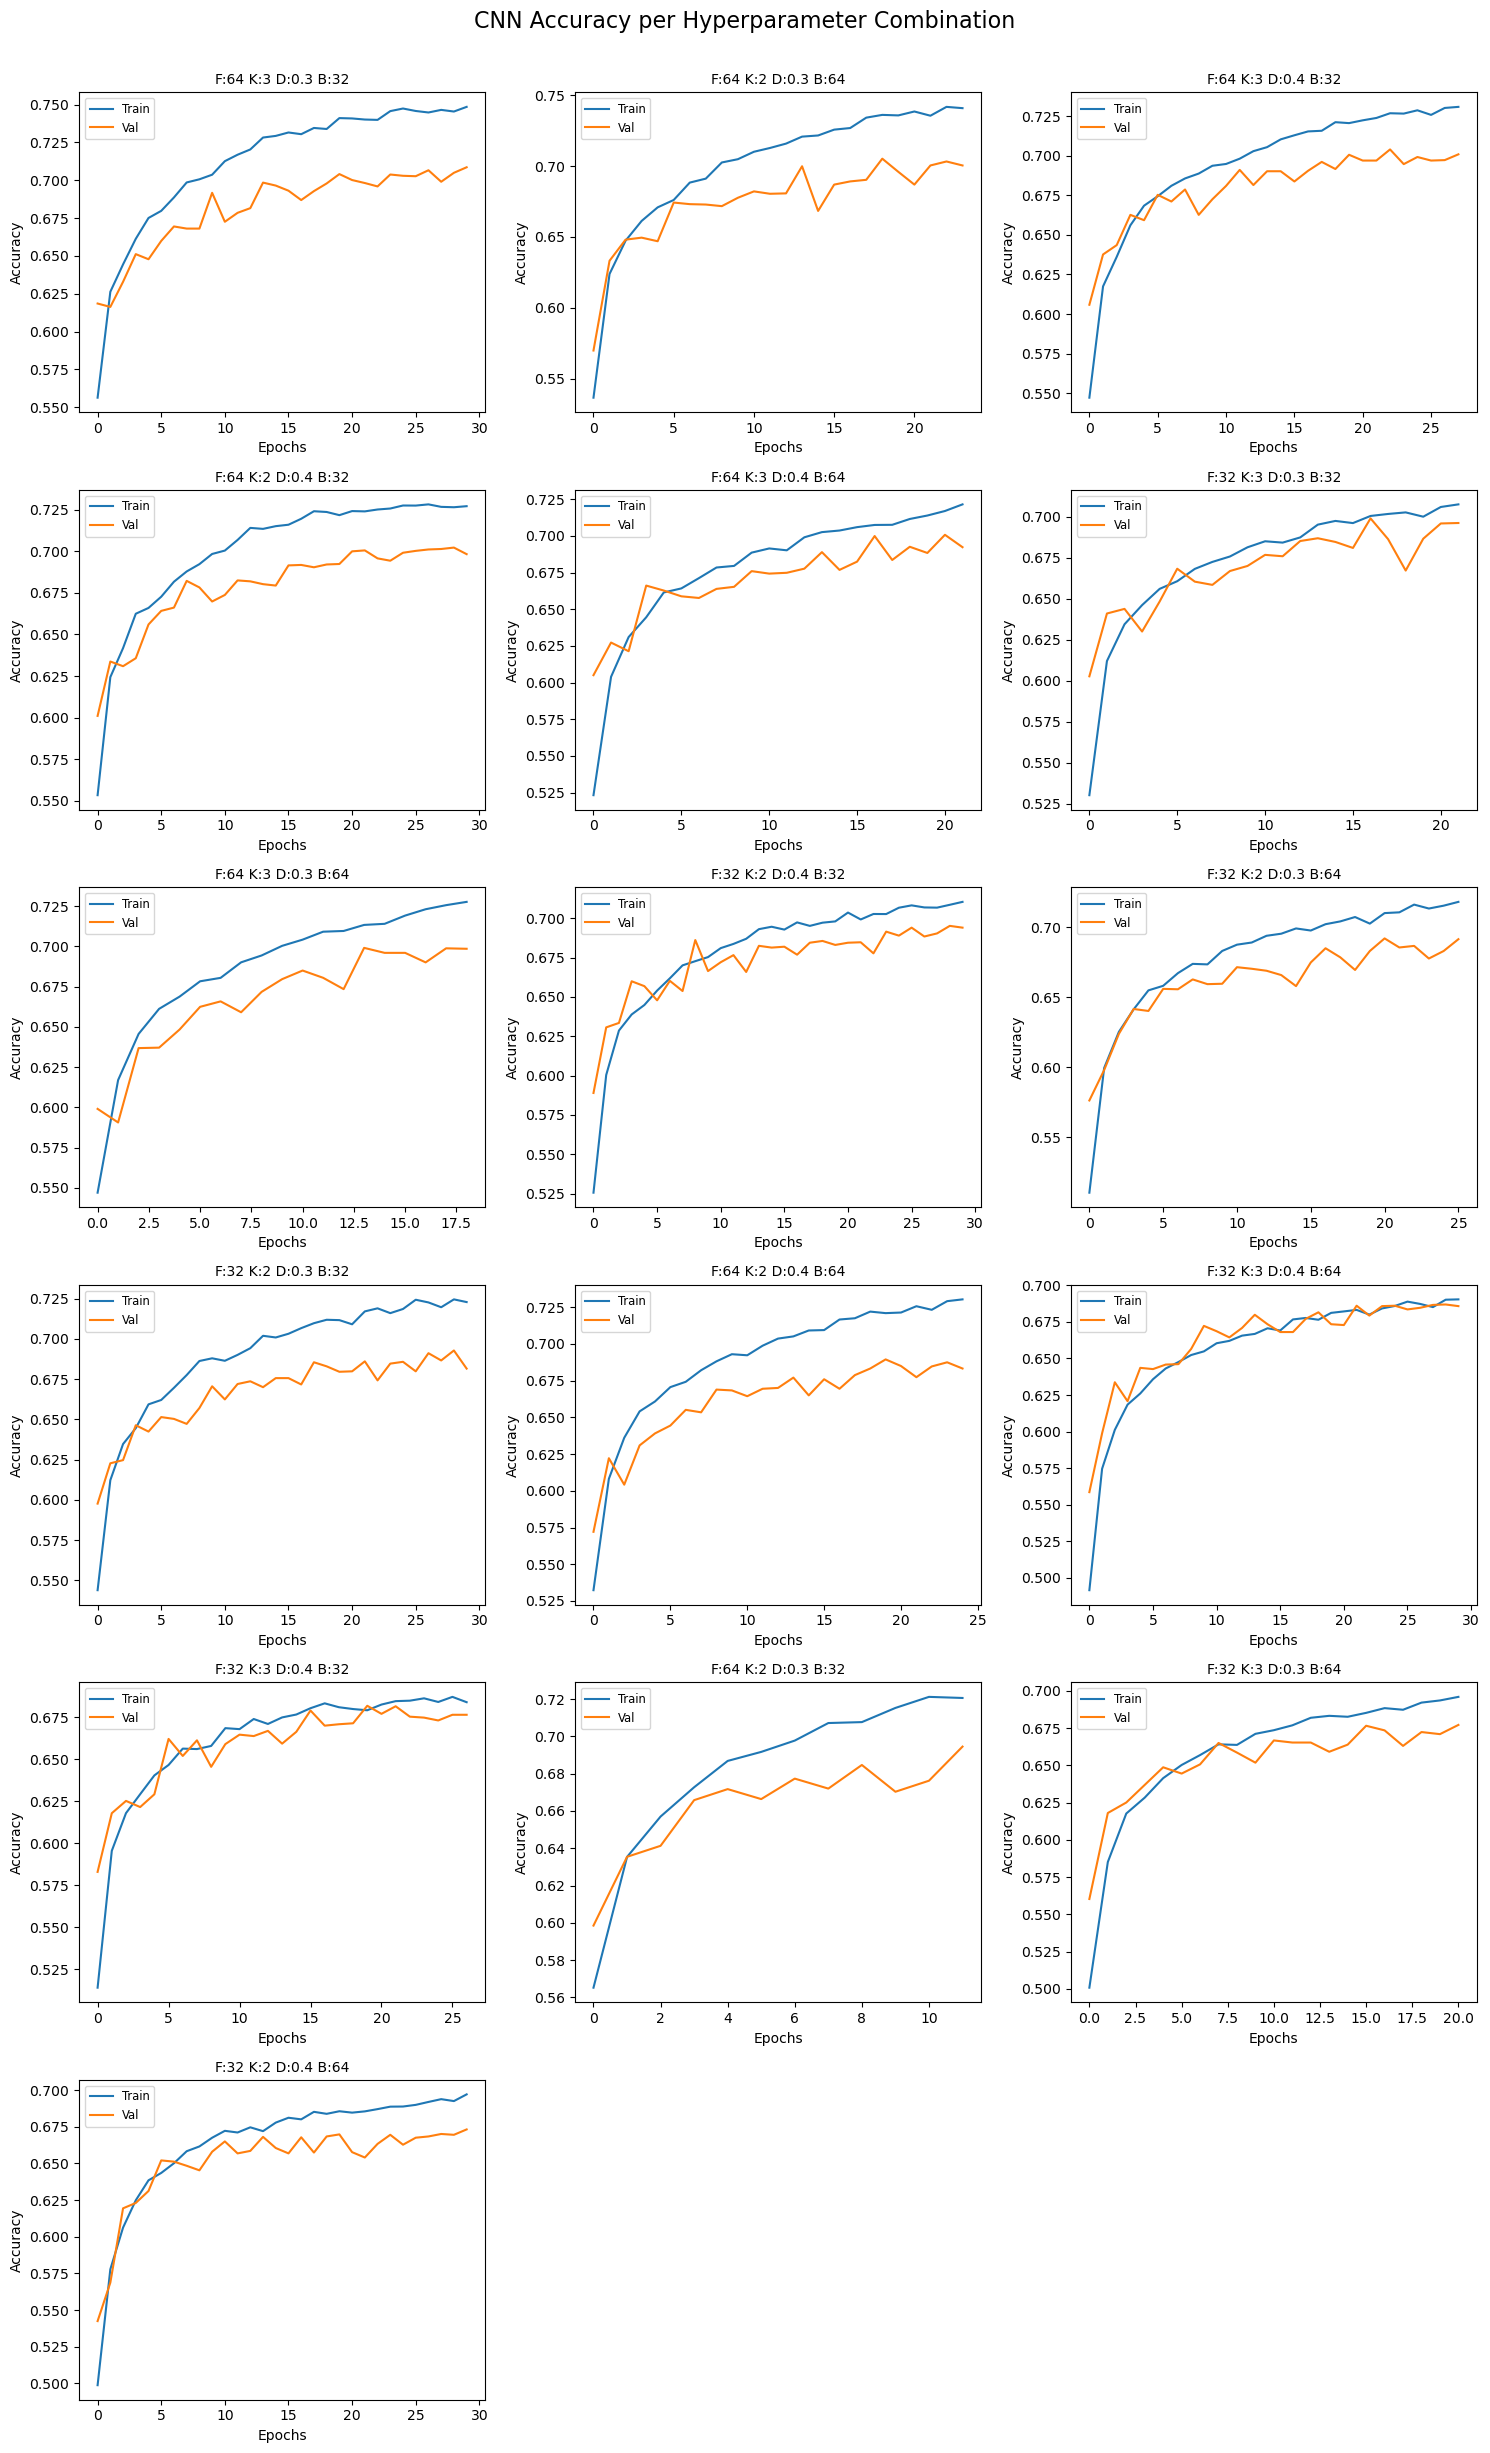

In [ ]:
# Sort by best val accuracy
import math
sorted_cnn_results = sorted(cnn_results, key=lambda x: x['val_accuracy'], reverse=True)

# Subplot settings
num_plots = len(sorted_cnn_results)
cols = 3
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(5 * cols, 4 * rows))

for i, res in enumerate(sorted_cnn_results):
    plt.subplot(rows, cols, i + 1)
    plt.plot(res['history']['accuracy'], label='Train')
    plt.plot(res['history']['val_accuracy'], label='Val')
    
    title = f"F:{res['params']['num_filters']} K:{res['params']['kernel_size']} D:{res['params']['dropout_rate']} B:{res['params']['batch_size']}"
    plt.title(title, fontsize=10)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(fontsize='small')
    plt.tight_layout()

plt.suptitle("CNN Accuracy per Hyperparameter Combination", fontsize=16, y=1.02)
plt.show()

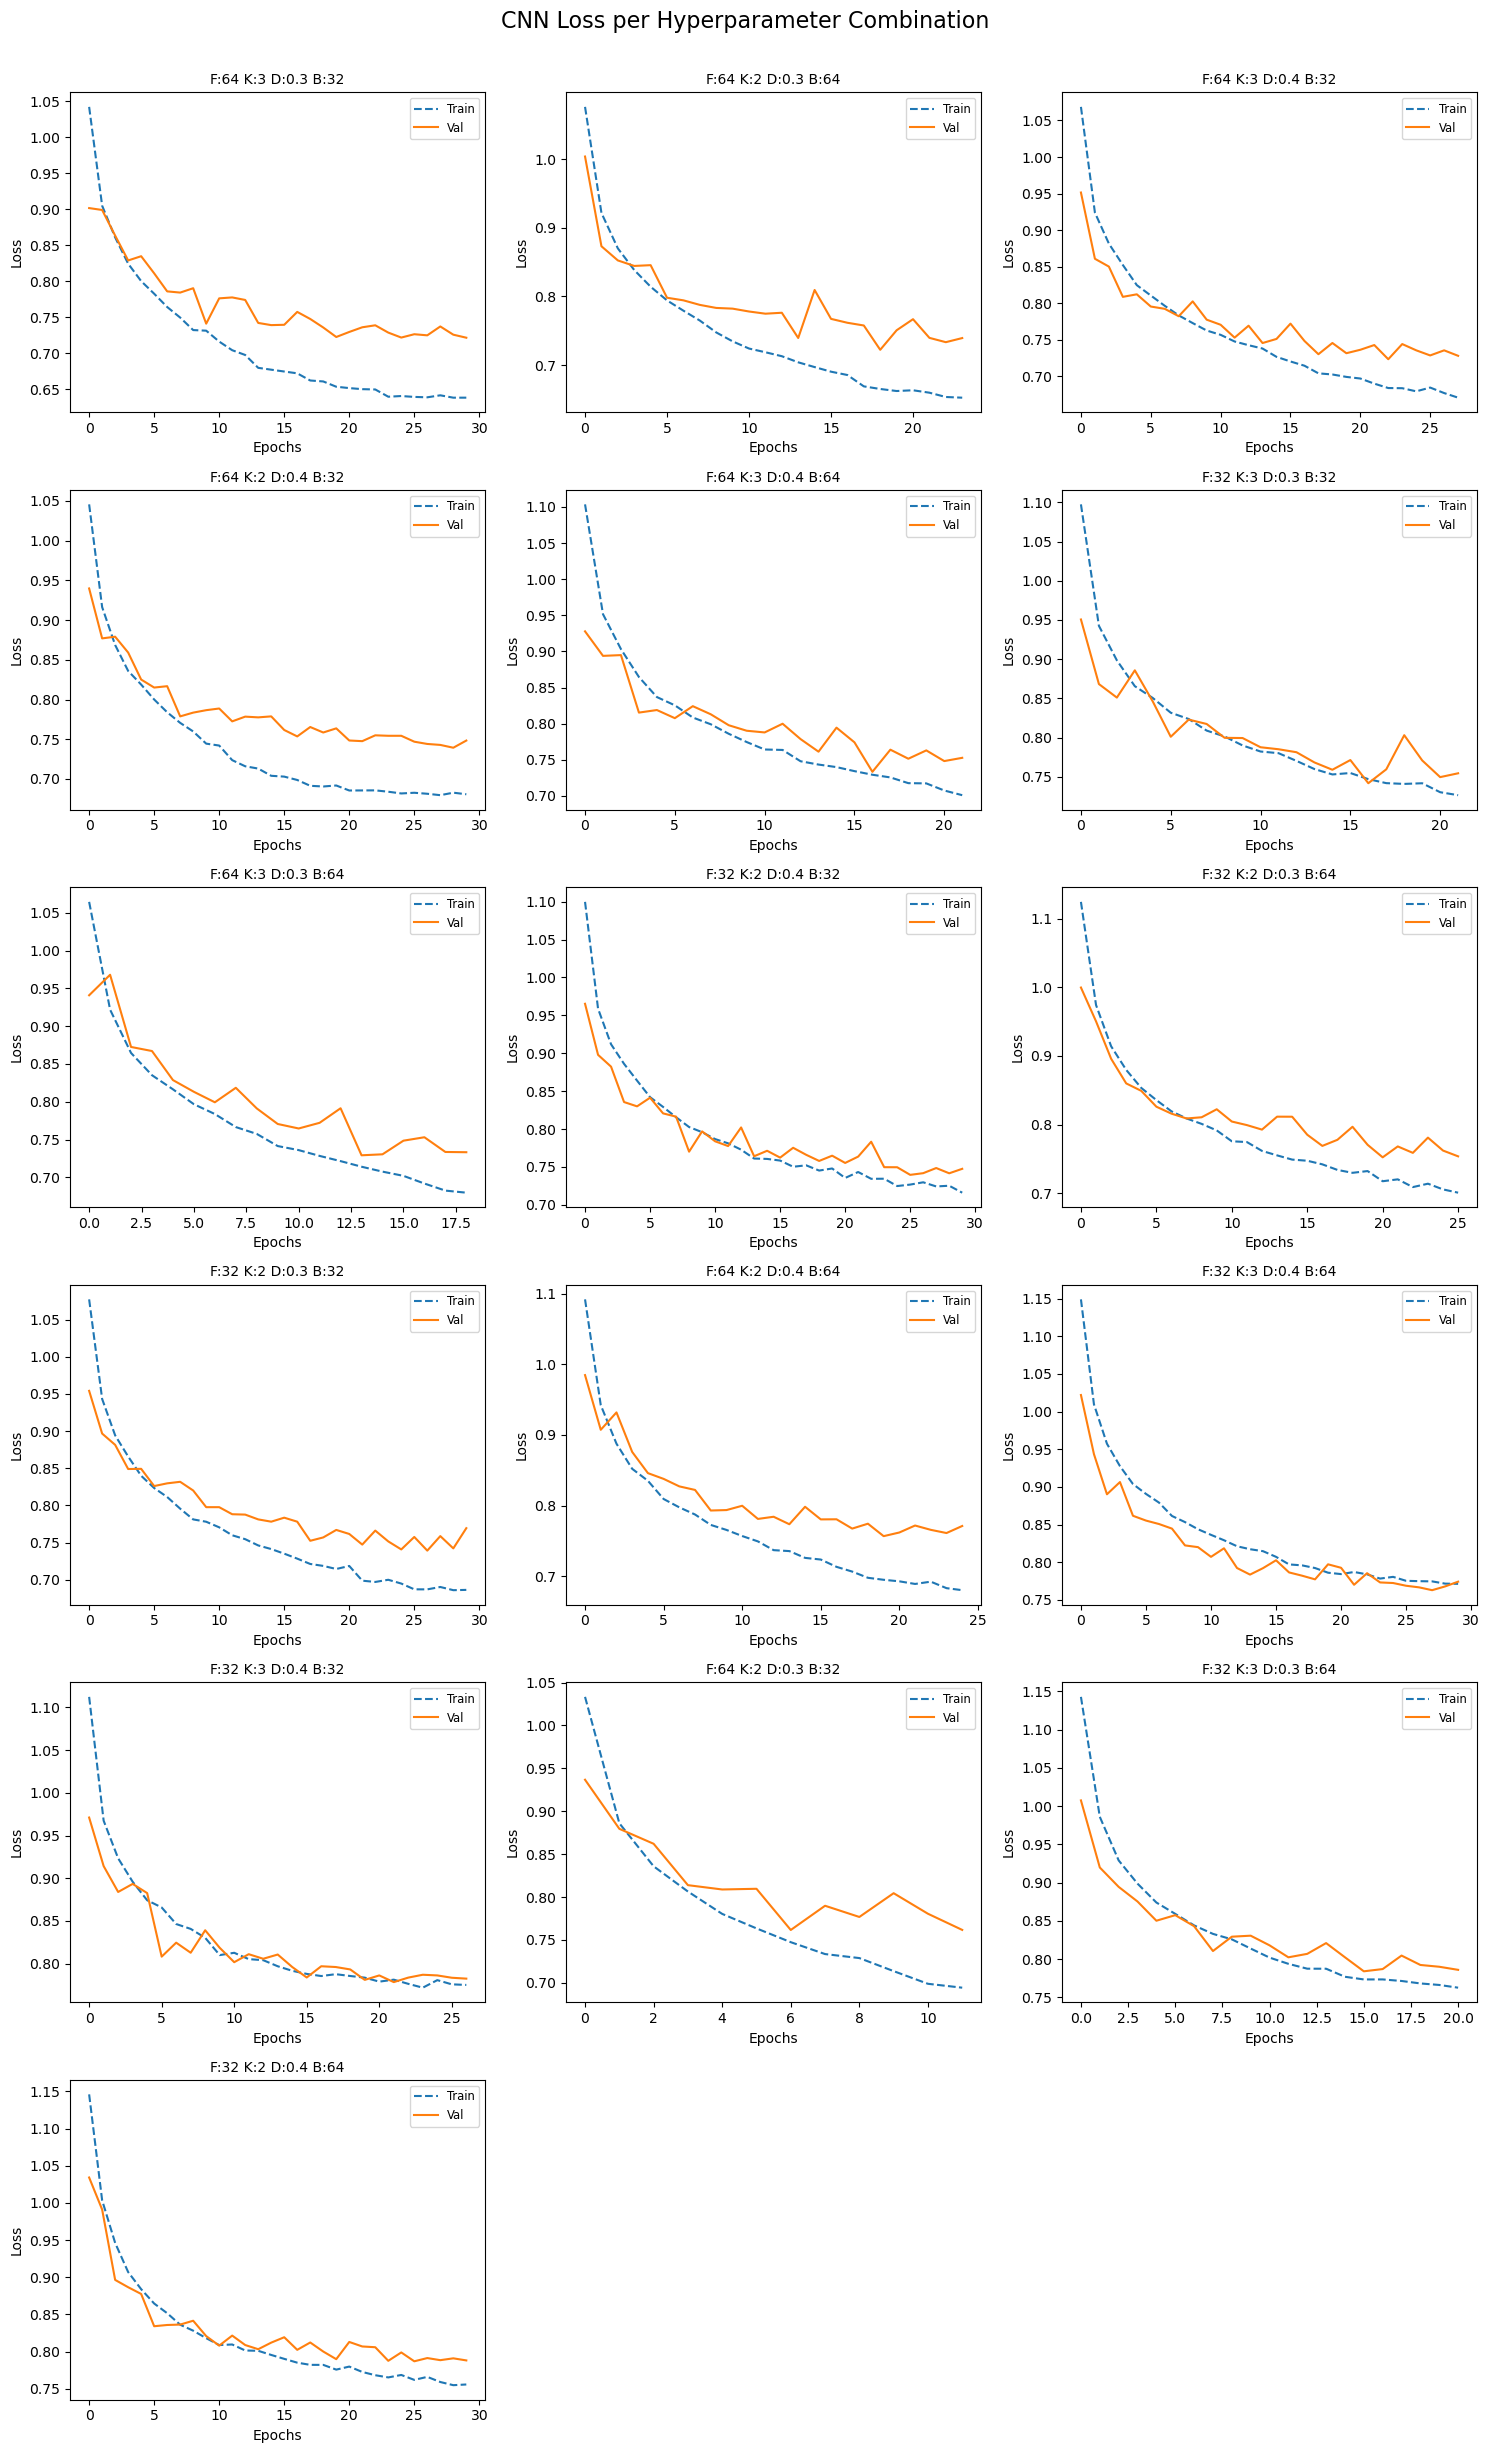

In [ ]:
plt.figure(figsize=(5 * cols, 4 * rows))

for i, res in enumerate(sorted_cnn_results):
    plt.subplot(rows, cols, i + 1)
    plt.plot(res['history']['loss'], linestyle='--', label='Train')
    plt.plot(res['history']['val_loss'], label='Val')
    
    title = f"F:{res['params']['num_filters']} K:{res['params']['kernel_size']} D:{res['params']['dropout_rate']} B:{res['params']['batch_size']}"
    plt.title(title, fontsize=10)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(fontsize='small')
    plt.tight_layout()

plt.suptitle("CNN Loss per Hyperparameter Combination", fontsize=16, y=1.02)
plt.show()

In [ ]:
# Get the best configuration
best_cnn_model = sorted_cnn_results[0]
best_params = best_cnn_model['params']

print("Best CNN Parameters:")
print(f"Filters: {best_params['num_filters']}")
print(f"Kernel Size: {best_params['kernel_size']}")
print(f"Dropout Rate: {best_params['dropout_rate']}")
print(f"Batch Size: {best_params['batch_size']}")

Best CNN Parameters:
Filters: 64
Kernel Size: 3
Dropout Rate: 0.3
Batch Size: 32


In [ ]:
# Rebuild the CNN model and train the model with best parameters
final_cnn_model = Sequential([
    Input(shape=(13, 1)),
    Conv1D(filters=best_params['num_filters'], kernel_size=best_params['kernel_size'], activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(best_params['dropout_rate']),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

final_cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Retrain on the full upsampled training set
final_history = final_cnn_model.fit(
    X_train_cnn_final, y_train_cnn_upsampled,
    epochs=50,
    batch_size=best_params['batch_size'],
    validation_data=(X_val_cnn_final, y_cnn_val),
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

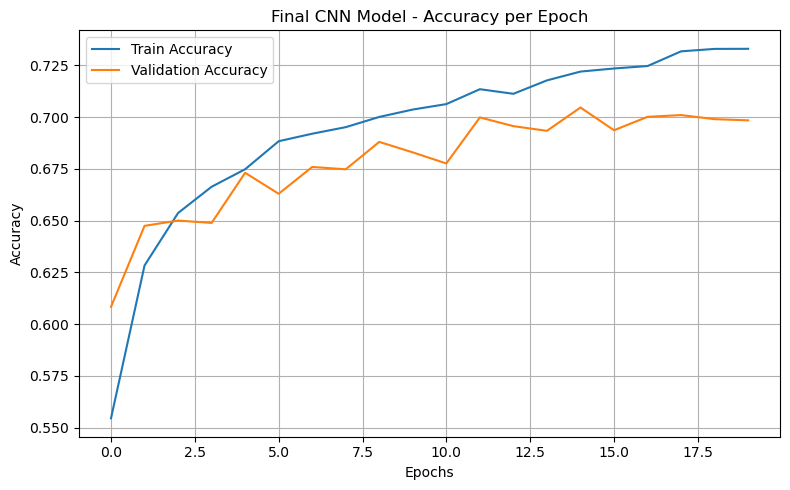

In [ ]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(8, 5))
plt.plot(final_history.history['accuracy'], label='Train Accuracy')
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Final CNN Model - Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

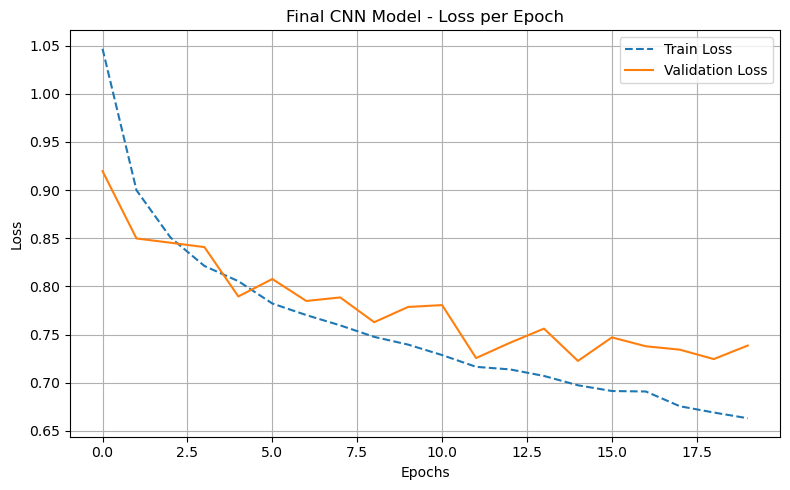

In [ ]:
# Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(final_history.history['loss'], label='Train Loss', linestyle='--')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title("Final CNN Model - Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on Test Set
test_loss, test_accuracy = final_cnn_model.evaluate(X_test_cnn_final, y_cnn_test, verbose=0)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

Final Test Accuracy: 0.7069
Final Test Loss: 0.7204


In [ ]:
final_cnn_model.save('composer_cnn_model.keras')  # Recommended format

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Classification Report:
              precision    recall  f1-score   support

        Bach       0.83      0.82      0.83      1124
   Beethoven       0.75      0.59      0.66      1184
      Chopin       0.44      0.72      0.55       230
      Mozart       0.64      0.71      0.67      1014

    accuracy                           0.71      3552
   macro avg       0.66      0.71      0.68      3552
weighted avg       0.72      0.71      0.71      3552



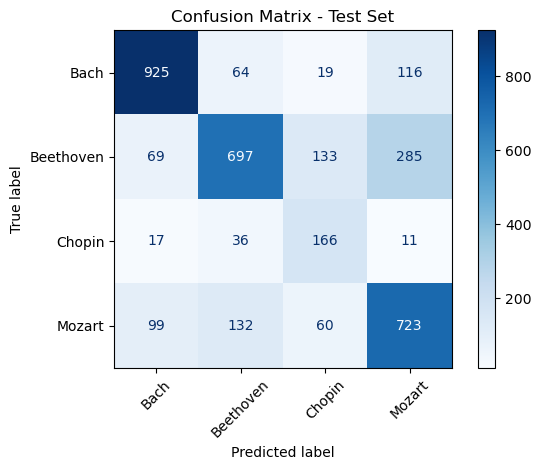

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get predicted class probabilities
y_test_probs = final_cnn_model.predict(X_test_cnn_final)

# Convert probabilities to class predictions
y_test_preds = np.argmax(y_test_probs, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_cnn_test, y_test_preds, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_cnn_test, y_test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()

Best Hyperparameters:
| Parameter     | Value |
|---------------|-------|
| Filters       | 64    |
| Kernel Size   | 3     |
| Dropout Rate  | 0.3   |
| Batch Size    | 32    |

Final test set performance:
| Metric   | Value   |
|----------|---------|
| Accuracy | 0.7069  |
| Loss     | 0.7204  |

Classification report:
| Composer   | Precision | Recall | F1-score | Support |
|------------|-----------|--------|----------|---------|
| Bach       | 0.83      | 0.82   | 0.83     | 1124    |
| Beethoven  | 0.75      | 0.59   | 0.66     | 1184    |
| Chopin     | 0.44      | 0.72   | 0.55     | 230     |
| Mozart     | 0.64      | 0.71   | 0.67     | 1014    |
| **Accuracy**   |           |        | **0.71**  | **3552** |
| **Macro Avg**  | 0.66      | 0.71   | 0.68     | 3552    |
| **Weighted Avg** | 0.72   | 0.71   | 0.71     | 3552    |

*	Strongest performance on Bach (F1: 0.83) and Mozart (F1: 0.67).
*	Chopin is the most difficult to classify — lower precision but decent recall, meaning many false positives.
*	Beethoven shows moderate performance but struggles with recall — misclassified more often than correctly classified.

Training and validation curves show consistent improvement, but:
*	A small gap remains --> potential mild overfitting.
*	Performance stabilizes after ~15–20 epochs.
*	Model generalizes fairly well given class imbalance and complexity of musical style classification.

Future enhancements can be,

*	Class Imbalance: Try focal loss or advanced augmentation for minority classes like Chopin.
*	Feature Engineering: Extract harmonic, melodic, and rhythmic features or spectrograms.
*	Model Complexity: Use deeper CNNs or hybrid models (e.g., CNN + LSTM).
*	Data Augmentation: Try time-stretching, transposition, or MIDI-specific augmentation.



### Implementation of Bidirectional LSTM with attention mechanism

In [34]:
# import additional libraries for Bidirectional LSTM

from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
from itertools import product
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir="  # clear CUDA libdevice path
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # ensure GPU is used (optional)

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices("GPU"))

TensorFlow version: 2.18.0
GPU devices: []


In [ ]:
# Prepare attention layer

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        e = K.squeeze(e, axis=-1)
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        return K.sum(x * alpha, axis=1)

In [ ]:
# LSTM + Attention Grid Search

lstm_param_grid = {
    'units': [64, 128],
    'dropout': [0.3, 0.4],
    'batch_size': [32, 64],
    'lr': [1e-3, 1e-4]
}

param_names = list(lstm_param_grid.keys())
param_combinations = list(product(*lstm_param_grid.values()))

In [ ]:
# train on different parameters for bidirectional LSTM + attention layers
lstm_results = []

for combo in param_combinations:
    params = dict(zip(param_names, combo))
    print(f"Training with: {params}")

    # Model definition
    inputs = Input(shape=(1, X_train_lstm.shape[2]))
    x = Bidirectional(LSTM(units=params['units'], return_sequences=True))(inputs)
    x = Attention()(x)
    x = Dropout(params['dropout'])(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(len(label_encoder.classes_), activation='softmax')(x)

    model = Model(inputs, outputs)

    optimizer = Adam(learning_rate=params['lr'])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

    history = model.fit(
        X_train_lstm, y_train_np,
        validation_data=(X_val_lstm, y_val_np),
        epochs=30,
        batch_size=params['batch_size'],
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    val_loss, val_accuracy = model.evaluate(X_val_lstm, y_val_np, verbose=0)

    lstm_results.append({
        'params': params,
        'val_accuracy': val_accuracy,
        'val_loss': val_loss,
        'history': history.history,
        'model': model
    })

Training with: {'units': 64, 'dropout': 0.3, 'batch_size': 32, 'lr': 0.001}
Training with: {'units': 64, 'dropout': 0.3, 'batch_size': 32, 'lr': 0.0001}
Training with: {'units': 64, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.001}
Training with: {'units': 64, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.0001}
Training with: {'units': 64, 'dropout': 0.4, 'batch_size': 32, 'lr': 0.001}
Training with: {'units': 64, 'dropout': 0.4, 'batch_size': 32, 'lr': 0.0001}
Training with: {'units': 64, 'dropout': 0.4, 'batch_size': 64, 'lr': 0.001}
Training with: {'units': 64, 'dropout': 0.4, 'batch_size': 64, 'lr': 0.0001}
Training with: {'units': 128, 'dropout': 0.3, 'batch_size': 32, 'lr': 0.001}
Training with: {'units': 128, 'dropout': 0.3, 'batch_size': 32, 'lr': 0.0001}
Training with: {'units': 128, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.001}
Training with: {'units': 128, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.0001}
Training with: {'units': 128, 'dropout': 0.4, 'batch_size': 32, 'lr': 0.001}
T

In [ ]:
# Sort by accuracy
sorted_lstm_results = sorted(lstm_results, key=lambda x: x['val_accuracy'], reverse=True)

best_lstm_model = sorted_lstm_results[0]['model']
best_params = sorted_lstm_results[0]['params']

print("Best Parameters:")
for k, v in best_params.items():
    print(f"{k}: {v}")

Best Parameters:
units: 64
dropout: 0.3
batch_size: 32
lr: 0.001


/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


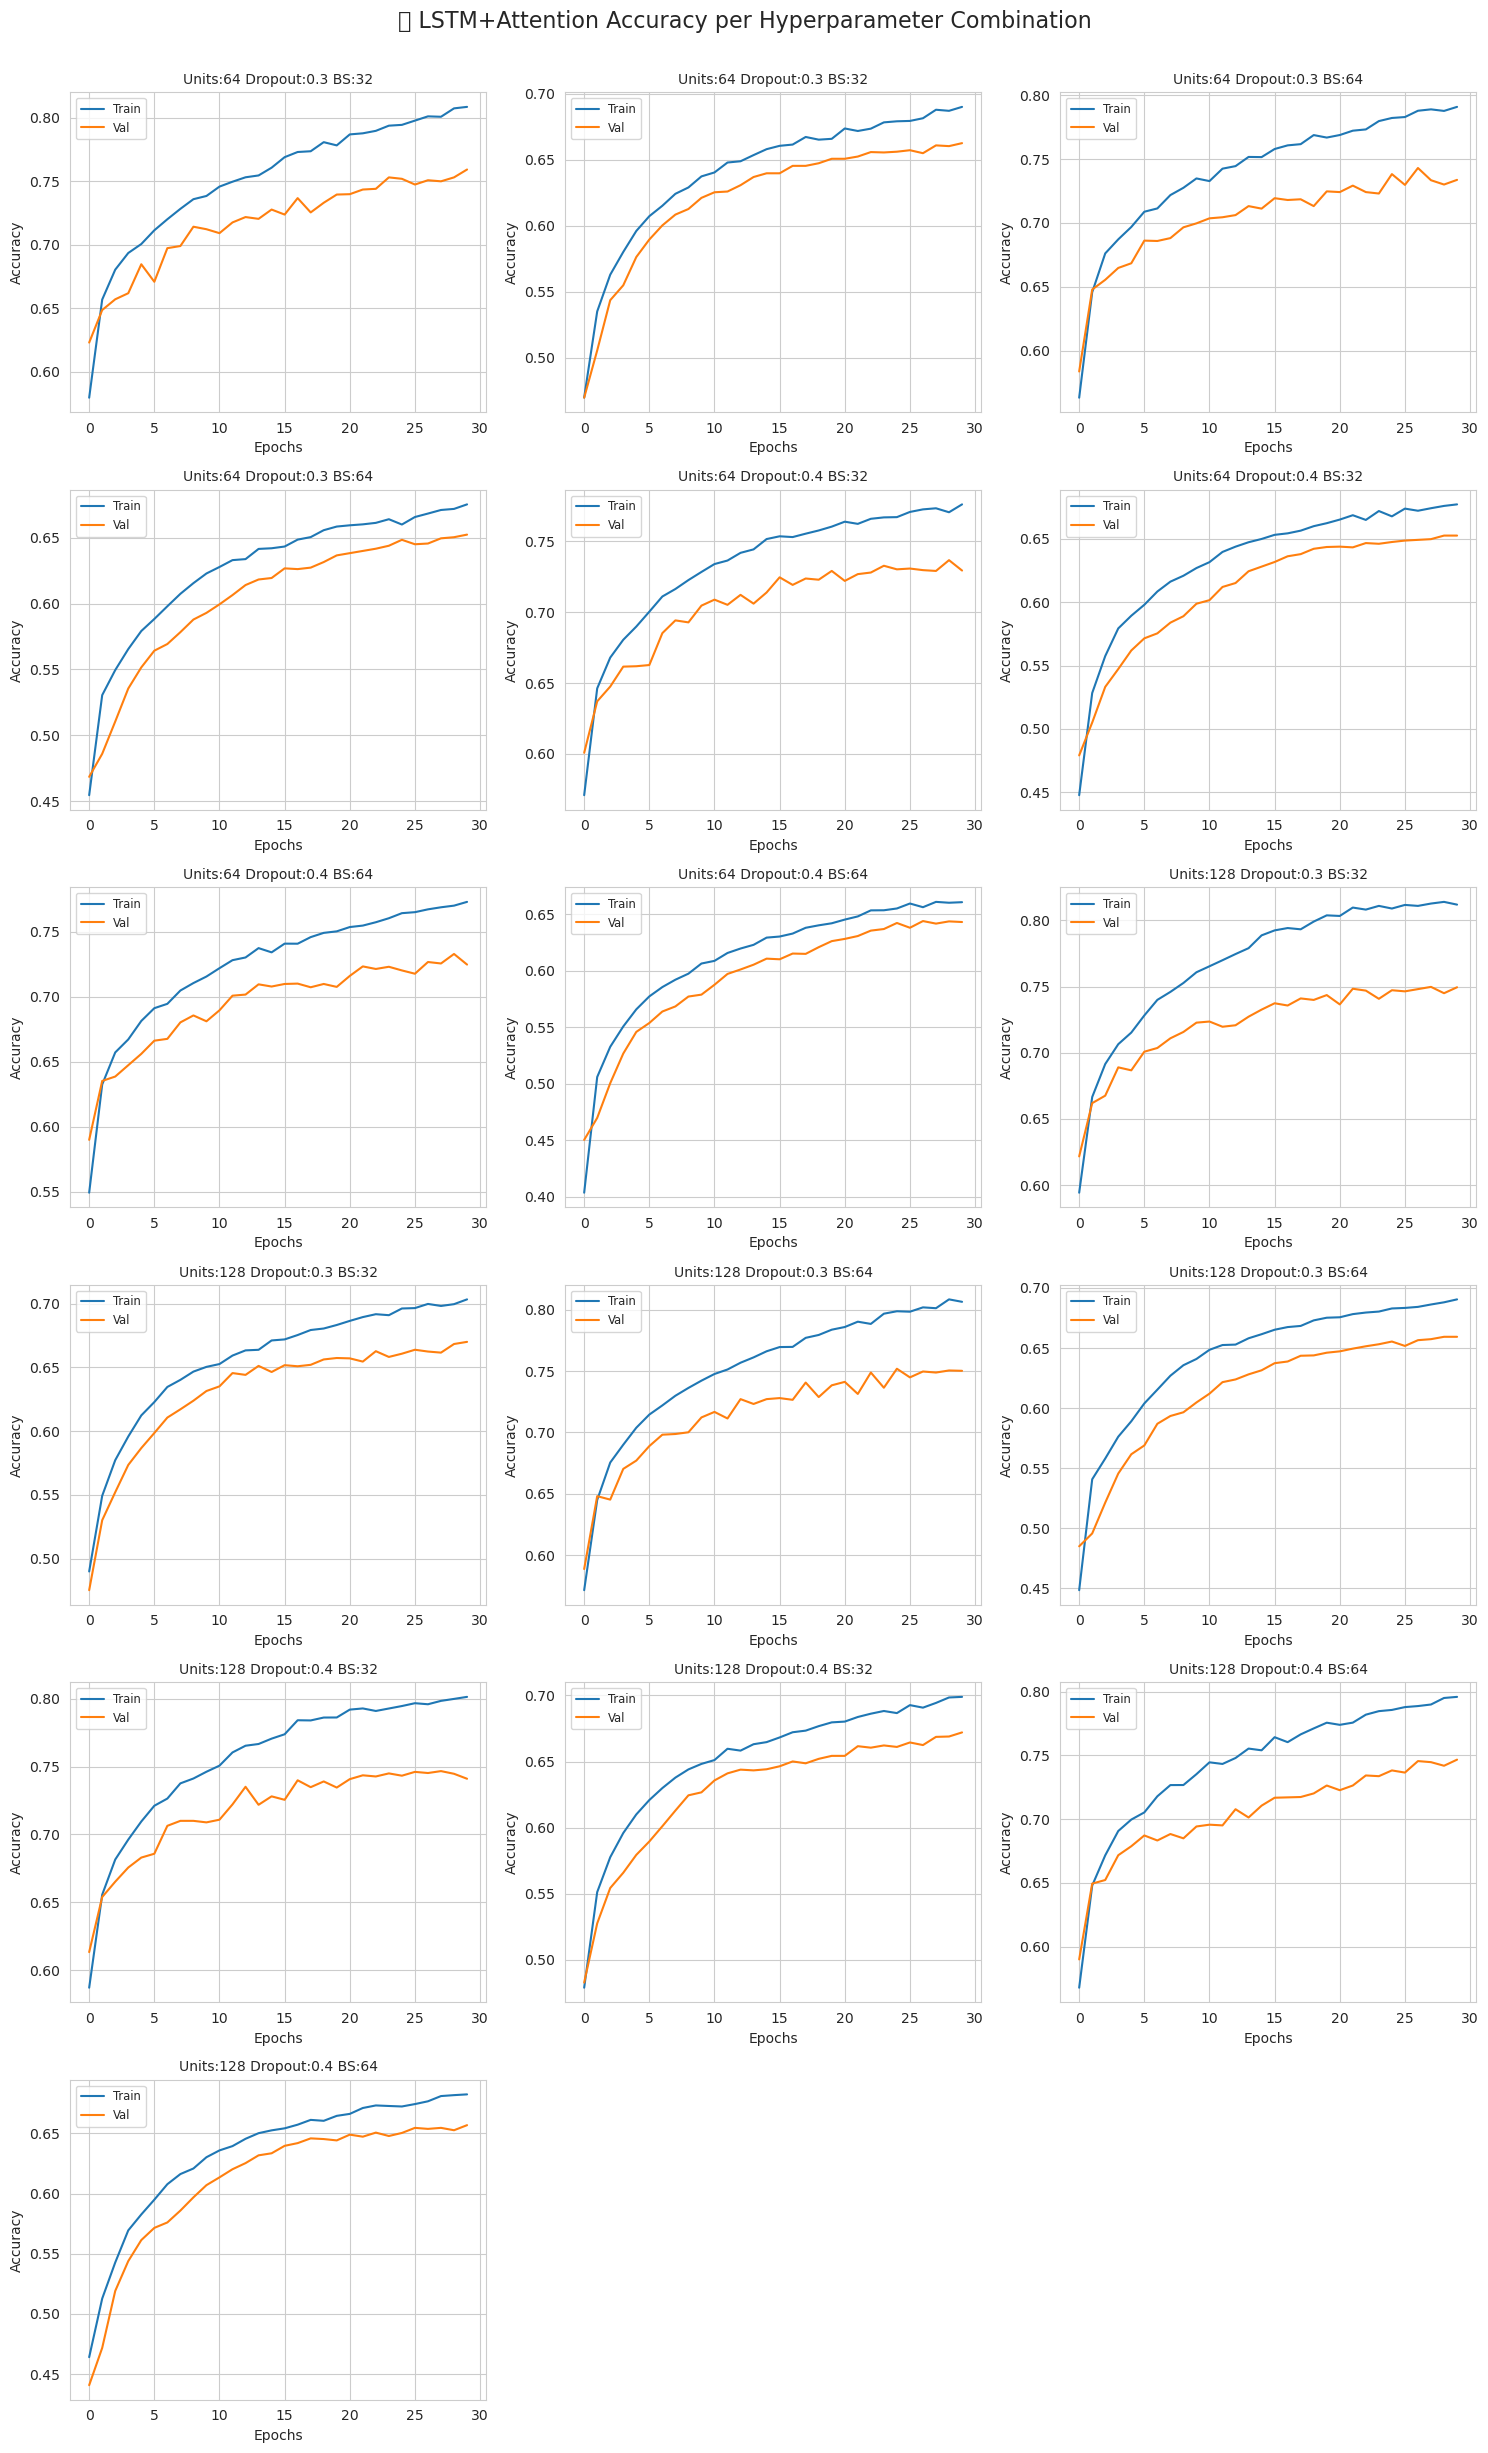

In [ ]:
# `lstm_attention_results` holds the results from grid search
num_plots = len(lstm_results)
cols = 3
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(5 * cols, 4 * rows))

for i, res in enumerate(lstm_results):
    plt.subplot(rows, cols, i + 1)
    plt.plot(res['history']['accuracy'], label='Train')
    plt.plot(res['history']['val_accuracy'], label='Val')
    params = res['params']
    title = f"Units:{params['units']} Dropout:{params['dropout']} BS:{params['batch_size']}"
    plt.title(title, fontsize=10)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(fontsize='small')
    plt.grid(True)

plt.tight_layout()
plt.suptitle("📈 LSTM+Attention Accuracy per Hyperparameter Combination", fontsize=16, y=1.02)
plt.show()

/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


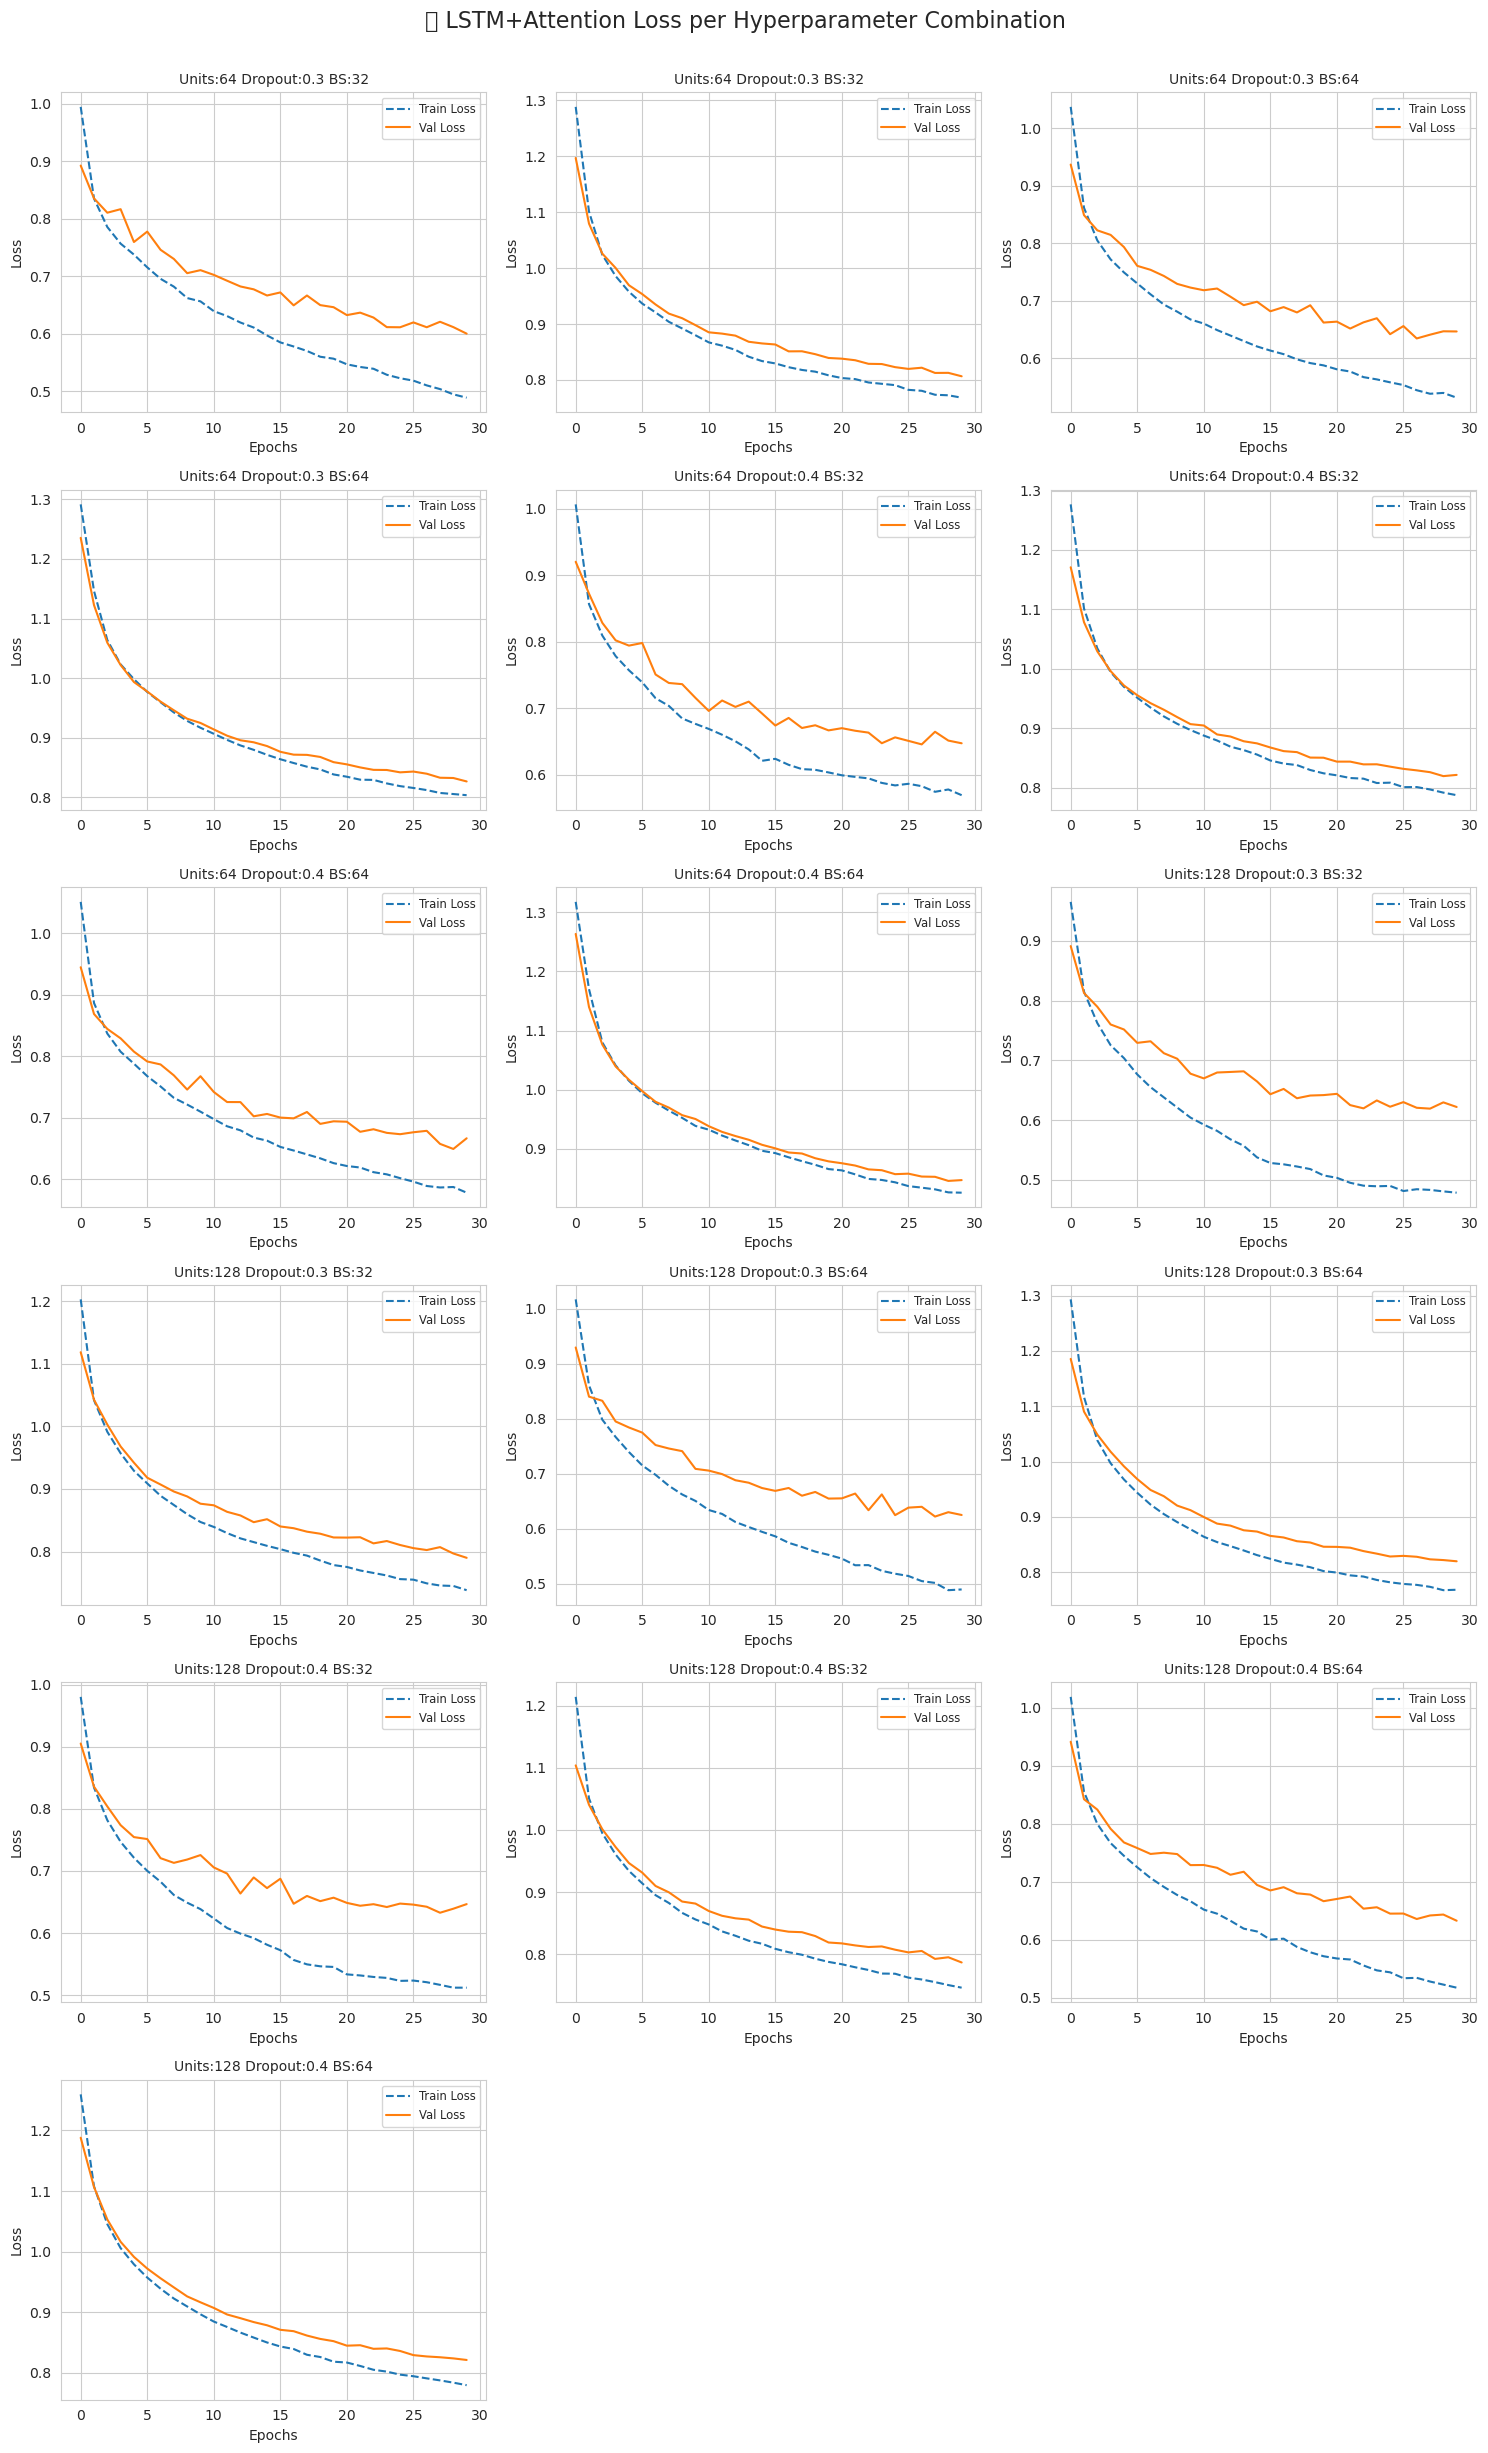

In [ ]:
plt.figure(figsize=(5 * cols, 4 * rows))

for i, res in enumerate(lstm_results):
    plt.subplot(rows, cols, i + 1)
    plt.plot(res['history']['loss'], label='Train Loss', linestyle='--')
    plt.plot(res['history']['val_loss'], label='Val Loss')
    params = res['params']
    title = f"Units:{params['units']} Dropout:{params['dropout']} BS:{params['batch_size']}"
    plt.title(title, fontsize=10)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(fontsize='small')
    plt.grid(True)

plt.tight_layout()
plt.suptitle("📉 LSTM+Attention Loss per Hyperparameter Combination", fontsize=16, y=1.02)
plt.show()

Based on your identified best hyperparameters:

*	LSTM Units: 128
*	Dropout: 0.3
*	Batch Size: 32
*	Learning Rate: 0.001

this combination offers the best balance of training and validation accuracy, with relatively lower validation loss and reduced overfitting compared to other configurations.

to implement a Bidirectional LSTM with an Attention Mechanism using these hyperparameters.

In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        e = K.tanh(K.dot(inputs, self.W) + self.b)
        e = K.squeeze(e, axis=-1)
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = inputs * alpha
        return K.sum(context, axis=1)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])  # (timesteps, features)

inputs = Input(shape=input_shape)
x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
x = AttentionLayer()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(len(label_encoder.classes_), activation='softmax')(x)

attention_model = Model(inputs, outputs)
attention_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

attention_model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 1, 256)         │       144,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_6               │ (None, 256)            │           257 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,349 (630.27 KB)

 Trainable params: 161,349 (630.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5)

history = attention_model.fit(
    X_train_lstm, y_train_np,
    validation_data=(X_val_lstm, y_val_np),
    epochs=300,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

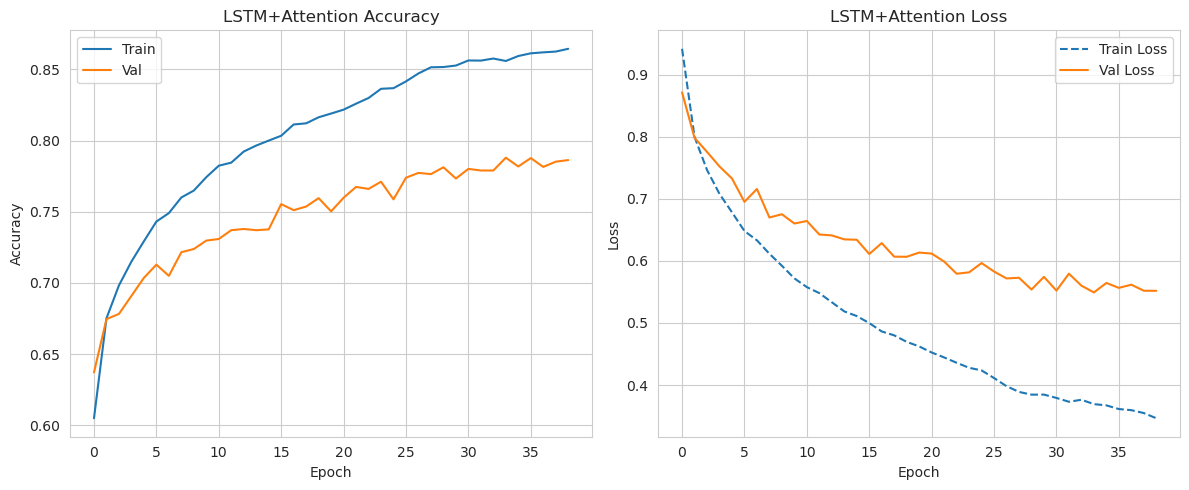

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('LSTM+Attention Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linestyle='--')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM+Attention Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Test Accuracy: 0.7841
Test Loss: 0.5500
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

        Bach       0.89      0.88      0.89      1124
   Beethoven       0.80      0.70      0.75      1184
      Chopin       0.54      0.83      0.65       230
      Mozart       0.74      0.76      0.75      1014

    accuracy                           0.78      3552
   macro avg       0.74      0.79      0.76      3552
weighted avg       0.79      0.78      0.79      3552



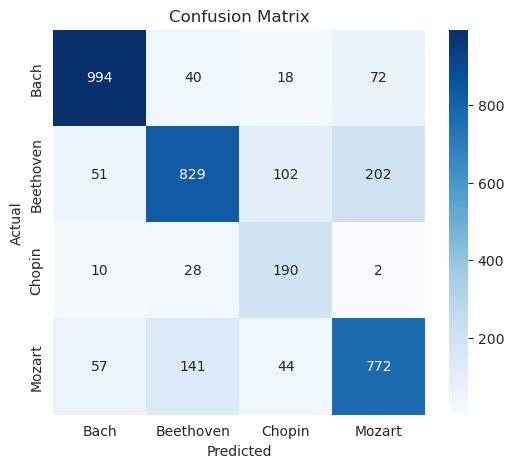

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

test_loss, test_accuracy = attention_model.evaluate(X_test_lstm, y_test_np, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predictions
y_pred = np.argmax(attention_model.predict(X_test_lstm), axis=1)

# Report
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test_np, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
attention_model.save("bidirectional_lstm_attention_model.keras")

Best Hyperparameters for LSTM Bidirectional + attention Model:

| Hyperparameter      | Value     |
|---------------------|-----------|
| Best Units          | 64        |
| Best Dropout        | 0.3       |
| Batch Size          | 32        |
| Learning Rate       | 0.001     |
| Epochs              | 300       |
| Validation Accuracy | ~78%      |

Classification Report:

| Composer   | Precision | Recall | F1-Score | Support |
|------------|-----------|--------|----------|---------|
| Bach       | 0.89      | 0.88   | 0.89     | 1124    |
| Beethoven  | 0.80      | 0.70   | 0.75     | 1184    |
| Chopin     | 0.54      | 0.83   | 0.65     | 230     |
| Mozart     | 0.74      | 0.76   | 0.75     | 1014    |
| **Accuracy**        |           |        | **0.78** | 3552    |
| **Macro Avg**       | 0.74      | 0.79   | 0.76     |         |
| **Weighted Avg**    | 0.79      | 0.78   | 0.79     |         |

Confusion matrix:

| Actual \ Predicted | Bach | Beethoven | Chopin | Mozart |
|--------------------|------|-----------|--------|--------|
| Bach               | 994  | 40        | 18     | 72     |
| Beethoven          | 51   | 829       | 102    | 202    |
| Chopin             | 10   | 28        | 190    | 2      |
| Mozart             | 57   | 141       | 44     | 772    |

### Insights:

*	Bidirectional LSTM with attention significantly improves temporal and contextual understanding of musical features.
*	Chopin benefits most from attention, achieving high recall (0.83), although precision is lower.
*	Bach remains the most accurately predicted composer (F1-score: 0.89).
*	The attention mechanism appears to help in disambiguating stylistic overlaps between composers.
*	Minor overfitting is visible (train > val accuracy), but performance is stable due to early stopping and dropout regularization.

### Conclusions:

*	Bach is most accurately classified with high precision (0.89) and recall (0.88), indicating the model effectively captures patterns unique to Bach’s style.
*	Beethoven tends to be misclassified as Mozart or Chopin, suggesting some overlapping musical features.
*	Chopin shows the lowest precision (0.54) but high recall (0.83), meaning the model frequently predicts Chopin correctly but also falsely assigns other samples as Chopin.
*	Mozart has a balanced precision and recall (~0.75), with moderate confusion from Beethoven and Bach.
*	Overall Accuracy of 78% shows that the model performs well, especially considering the multi-class complexity.
*	The attention mechanism with bidirectional LSTM successfully captures both forward and backward temporal dependencies, enhancing classification performance.






### Comparisions of all the three models evaluated.

Here’s a comparison table of performance metrics (Precision, Recall, F1-Score, Accuracy) for the three models evaluated:

Per class and per model comparisions:

| Composer   | Model                | Precision | Recall | F1-Score | Support |
|------------|----------------------|-----------|--------|----------|---------|
| Bach       | LSTM                 | 0.87      | 0.84   | 0.85     | 1124    |
|            | CNN                  | 0.83      | 0.82   | 0.83     | 1124    |
|            | BiLSTM + Attention   | 0.89      | 0.88   | 0.89     | 1124    |
| Beethoven  | LSTM                 | 0.80      | 0.64   | 0.71     | 1184    |
|            | CNN                  | 0.75      | 0.59   | 0.66     | 1184    |
|            | BiLSTM + Attention   | 0.80      | 0.70   | 0.75     | 1184    |
| Chopin     | LSTM                 | 0.47      | 0.82   | 0.59     | 230     |
|            | CNN                  | 0.44      | 0.72   | 0.55     | 230     |
|            | BiLSTM + Attention   | 0.54      | 0.83   | 0.65     | 230     |
| Mozart     | LSTM                 | 0.68      | 0.75   | 0.72     | 1014    |
|            | CNN                  | 0.64      | 0.71   | 0.67     | 1014    |
|            | BiLSTM + Attention   | 0.74      | 0.76   | 0.75     | 1014    |


Overall Model Metrics:

| Metric               | LSTM | CNN  | BiLSTM + Attention |
|----------------------|------|------|---------------------|
| Accuracy             | 0.75 | 0.71 | 0.78                |
| Macro Avg Precision  | 0.70 | 0.66 | 0.74                |
| Macro Avg Recall     | 0.76 | 0.71 | 0.79                |
| Macro Avg F1-Score   | 0.72 | 0.68 | 0.76                |
| Weighted Avg Precision | 0.77 | 0.72 | 0.79              |
| Weighted Avg Recall  | 0.75 | 0.71 | 0.78                |
| Weighted Avg F1-Score| 0.75 | 0.71 | 0.79                |
| Total Support        | 3552 | 3552 | 3552                |

Insights from Per-Class Performance on F1-scores:

| Composer   | Best Performing Model               | Observations                                                                 |
|------------|-------------------------------------|------------------------------------------------------------------------------|
| **Bach**       | **BiLSTM + Attention (F1: 0.89)**   | Very consistent performer across all models. BiLSTM+Attention achieves the highest precision and F1. |
| **Beethoven**  | **BiLSTM + Attention (F1: 0.75)**   | Significant improvement in recall compared to CNN (0.70 vs. 0.59), improving the overall F1-score. |
| **Chopin**     | **BiLSTM + Attention (F1: 0.65)**   | This class benefits the most from attention. Earlier models had lower precision. |
| **Mozart**     | **BiLSTM + Attention (F1: 0.75)**   | Moderate gains over LSTM and CNN; best F1 overall. |

Insights from Overall Metrics:


| Metric                 | Best Model                     | Why?                                                                                  |
|------------------------|--------------------------------|----------------------------------------------------------------------------------------|
| **Accuracy**           | **BiLSTM + Attention (0.78)**  | Highest overall accuracy.                                                             |
| **Macro Avg F1-Score** | **BiLSTM + Attention (0.76)**  | Strong balance across all classes.                                                    |
| **Weighted Avg F1-Score** | **BiLSTM + Attention (0.79)**  | Indicates consistently good performance even for imbalanced classes.                  |
| **Macro Avg Recall**   | **BiLSTM + Attention (0.79)**  | Suggests better class sensitivity across the board.                                   |

### Conclusions and recommendations:

The Bidirectional LSTM with Attention mechanism outperforms both the plain LSTM and CNN models across all key performance metrics. Its enhanced sequence modeling capability (due to bidirectionality) and the attention mechanism help the model focus on relevant time steps in musical sequences, which is particularly beneficial in music classification tasks.

Recommended Model: Bidirectional LSTM + Attention

*	Strongest F1-scores across all composers.
*	Most balanced precision/recall tradeoff.
*	Best suited for handling temporal dependencies and class imbalance (especially seen in Chopin’s class improvement).